# **Predicting CO² Emission by Vehicles** 
## **Exploratory Data Analysis (EDA)**

<!DOCTYPE html>
<html>
<head>
<style>
  .centered-image {
    display: block;
    margin: 0 auto;
    max-width: 30%; /* Hier können Sie die maximale Breite einstellen */
    height: auto;    /* Das Verhältnis wird beibehalten */
  }
</style>
</head>
<body>
  <a href=>
    <img class="centered-image" src="https://static.vecteezy.com/system/resources/previews/005/893/697/non_2x/car-emits-co2-gas-pollution-of-carbon-dioxide-from-traffic-co2-cloud-gas-icon-traffic-pollution-from-vehicle-icon-illustration-vector.jpg" alt="Co2_cars">
  </a>
</body>
</html>

## **Load data**

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [90]:
# Scripts was initally used locally, so the data path is different
df = pd.read_csv("../data/data_2021_CO2_Project.csv")

## **Preprocessing EDA**

In [91]:
# repeating preprocessing exept label encoding / one hot encoding
# Remove columns with 100% missing values
df.dropna(axis = 1, how = 'all', inplace = True)
# Recuce dataset to France only
df = df[df.Country == 'FR']
#Rename columns
renaming_mapping = {col : col.replace(' ', '_')
                    .replace(')', '')
                    .replace('(', '')
                    for col in df.columns}
renaming_mapping['Electric range (km)'] = 'Er_km'
renaming_mapping['Fuel consumption '] = 'Fc'
renaming_mapping['Date of registration'] = 'Rd'
df.rename(columns = renaming_mapping, inplace = True)
# dropping columns with too many categories
df = df[['Mp','Cr','m_kg','Ewltp_g/km','W_mm','At1_mm','Ft','Fm','ec_cm3','ep_KW','z_Wh/km','IT','Erwltp_g/km','Fc','Er_km']]
# Dropping lines if missing values <1%
df = df.drop(df.loc[df.Mp.isna()].index, axis=0)
# Dropping non-polluting cars
df = df.drop(df.loc[df.Ft.isin(['ELECTRIC', 'UNKNOWN', 'HYDROGEN'])].index, axis=0)
#Dropping 'NG', 'NG-BIOMETHANE' categories due to very low observations percentages
df.drop(df.loc[df.Ft.isin(['NG', 'NG-BIOMETHANE'])].index, inplace=True)
#Filling missing values for z_Wh/km by 0 if car is not Hybrid
df.loc[((df['z_Wh/km'].isna()) & (df.Ft.isin(['PETROL', 'DIESEL', 'NG-BIOMETHANE', 'NG', 'E85', 'LPG']))),'z_Wh/km'] = 0
#Setting It to 0/1 depending if the value has or not an IT tech
df.IT = np.where(df.IT.isna(), 0, 1)
#Filling Electric range (km) is 0 for non_hybrid cars
df.Er_km = np.where(~df.Ft.isin(['PETROL/ELECTRIC', 'DIESEL/ELECTRIC']), 0, df.Er_km)
#Filling missing values for Erwltp_g/km with 0
df['Erwltp_g/km'] = df['Erwltp_g/km'].fillna(0)
fc_med_per_ft_category = df.groupby(['Ft'])['Fc'].median()
# Create a new column with median values based on 'Ft'
df['Fc_median'] = df['Ft'].map(fc_med_per_ft_category)
# Fill missing values in 'Fc' based on the corresponding 'Fc_median' values
df['Fc'].fillna(df['Fc_median'], inplace=True)
# Drop the temporary 'Fc_median' column if you no longer need it
df.drop('Fc_median', axis=1, inplace=True)
#Grouping cars into new categories Hybrid for 'PETROL/ELECTRIC' and 'DIESEL/ELECTRIC', others for 'E85', 'LPG' to deal with very low observations percentages
df.Ft = df.Ft.replace({'PETROL/ELECTRIC' : 'HYBRID', 'DIESEL/ELECTRIC' : 'HYBRID', 'E85' : 'OTHER', 'LPG' : 'OTHER'})



In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589748 entries, 183427 to 7896715
Data columns (total 15 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Mp           1589748 non-null  object 
 1   Cr           1589748 non-null  object 
 2   m_kg         1589748 non-null  float64
 3   Ewltp_g/km   1589748 non-null  float64
 4   W_mm         1589748 non-null  float64
 5   At1_mm       1589748 non-null  float64
 6   Ft           1589748 non-null  object 
 7   Fm           1589748 non-null  object 
 8   ec_cm3       1589748 non-null  float64
 9   ep_KW        1589748 non-null  float64
 10  z_Wh/km      1589748 non-null  float64
 11  IT           1589748 non-null  int32  
 12  Erwltp_g/km  1589748 non-null  float64
 13  Fc           1589748 non-null  float64
 14  Er_km        1589748 non-null  float64
dtypes: float64(10), int32(1), object(4)
memory usage: 188.0+ MB


## **Univariate Analysis**
### **Overview**
As the next step in our analytical journey, we are poised to conduct a univariate analysis. This fundamental approach involves examining individual variables to unravel insights into their distribution, central tendencies, and variations. Through this exploration, we aim to gain a preliminary understanding of the structure and characteristics of each variable in isolation. 


In [93]:
# Calculate statistical metrics
stats = df.describe()

# Define a color map
cmap = sns.light_palette("seagreen", as_cmap=True)

# Format the values in the DataFrame to 2 decimal places
styled_stats = stats.style.format("{:.2f}").background_gradient(cmap=cmap, axis=1)

# Display the formatted statistical metrics
styled_stats


,m_kg,Ewltp_g/km,W_mm,At1_mm,ec_cm3,ep_KW,z_Wh/km,IT,Erwltp_g/km,Fc,Er_km
count,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00,1589748.00
mean,1364.92,120.23,2625.14,1539.53,1396.17,89.01,14.97,0.71,1.08,5.13,4.69
std,268.08,30.03,123.44,50.41,372.97,31.13,51.36,0.45,0.80,1.32,15.84
min,910.00,4.00,2250.00,1390.00,647.00,28.00,0.00,0.00,0.00,0.60,0.00
25%,1165.00,115.00,2552.00,1506.00,999.00,69.00,0.00,0.00,0.00,4.90,0.00
50%,1313.00,124.00,2605.00,1544.00,1395.00,84.00,0.00,1.00,1.10,5.30,0.00
75%,1504.00,135.00,2675.00,1569.00,1499.00,100.00,0.00,1.00,1.90,5.70,0.00
max,2785.00,373.00,3750.00,1810.00,6749.00,537.00,373.00,1.00,2.90,16.40,199.00


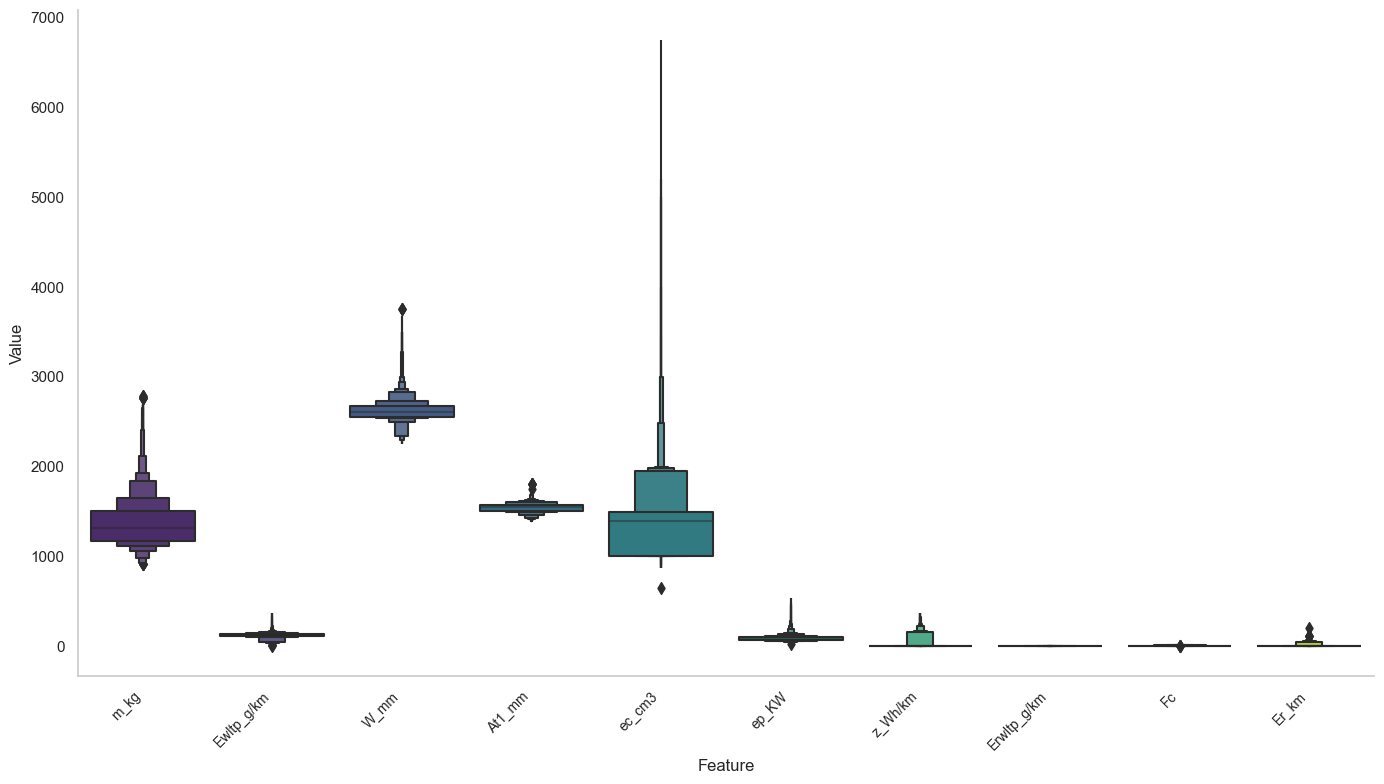

In [94]:
# Create a subset of the DataFrame with only numerical variables
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Set seaborn style without grid lines
sns.set(style="whitegrid", rc={"axes.grid": False})

# Choose a beautiful color palette
colors = sns.color_palette("viridis", n_colors=len(numeric_df.columns))

# Create a boxenplot for numerical variables
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxenplot(data=numeric_df, palette=colors)
ax.set_title('', fontsize=20, fontweight='bold', pad=20, loc="left")
ax.set_ylabel('Value', fontsize=12)
ax.set_xlabel('Feature', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

# Remove top and right spines
sns.despine(top=True, right=True)

# Show the plot
plt.tight_layout()
plt.show()


The boxplot you see above, illustrates the distribution of numerical features in our dataset, providing insights into their central tendency and spread. As we can see, the variables in our dataset exhibit diverse scales and ranges, exemplified by the weight of vehicles ranging from 910 to 2785 kg and engine power varying between 28 and 537 kW. A prevalent characteristic is the positive skewness in most variables, indicated by an upward tail in their distributions. This suggests that the majority of vehicles tend to have lower values, but a subset of vehicles exhibits higher values, impacting the overall average. Additionally, the standard deviations for some variables are notably high, signaling a broad dispersion of data points around the mean.

Several variables, including 'Ewltp_g/km', 'ec _cm3', 'ep_KW', 'z_Wh/km', and 'Erwltp_g/km)', share similar distribution patterns marked by positive skewness. This commonality suggests that a significant portion of vehicles tends to have lower emissions, smaller engine displacements, lower power, reduced energy consumption, and lower emission factors. In contrast, variables such as 'm_kg', 'W_mm', 'At1_mm', and 'Fc' also exhibit positive skewness but with distinct ranges and scales.
The presence of outliers and extreme values in some variables poses potential challenges for modeling. Addressing these outliers with careful consideration is imperative to ensure model robustness. Furthermore, the positive skewness in distributions indicates a departure from normality, prompting exploration of transformations, such as log transformations, to align the data more closely with a normal distribution.

To prepare the data for modeling, it is crucial to identify and appropriately address outliers within the variables. Using transformations becomes essential, particularly if the chosen Machine Learning model assumes a normal distribution of data. Additionally, acknowledging the varying scales of the variables is vital when selecting algorithms to guarantee their adaptability to the diverse magnitudes present in the dataset. These general insights lay the groundwork for more in-depth analyses of individual variables, providing a comprehensive understanding of the dataset for effective model development.


### **Manufacturer**

The following visuals offer a detailed look into the landscape of non-electric vehicles registered in 2021, shedding light on their distribution and average CO² emissions. The first barplot provides a comprehensive overview of the dataset, showcasing the distribution of car counts among various manufacturers. Let's delve into the details:

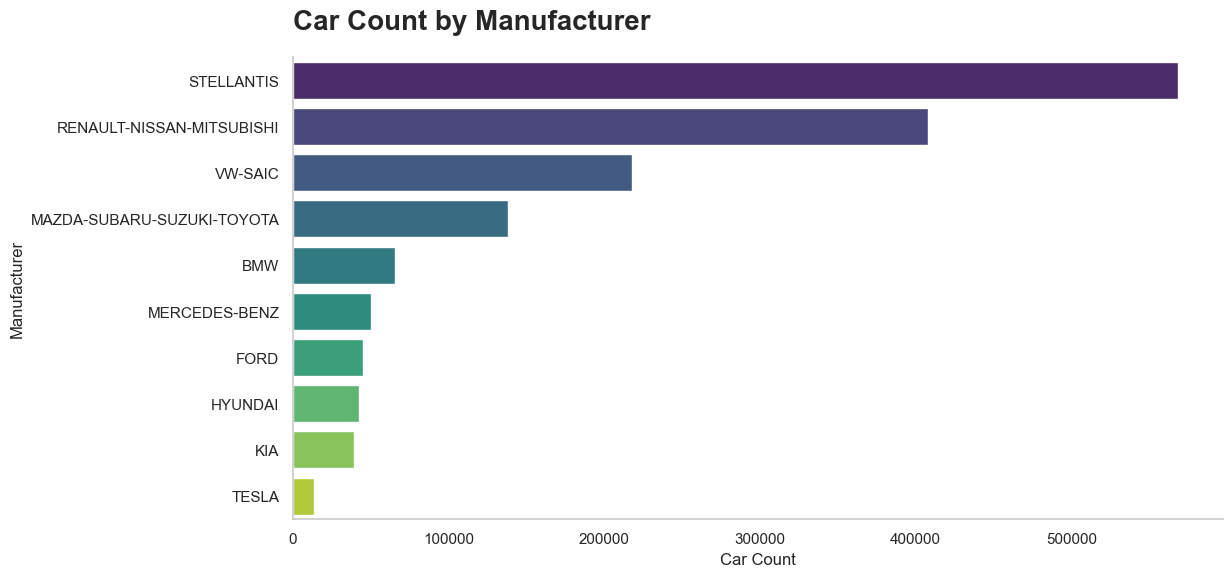

Car Count by Manufacturer:


,Manufacturer,Car Count
0,STELLANTIS,568603
1,RENAULT-NISSAN-MITSUBISHI,407971
2,VW-SAIC,218025
3,MAZDA-SUBARU-SUZUKI-TOYOTA,138220
4,BMW,65550
5,MERCEDES-BENZ,50575
6,FORD,45176
7,HYUNDAI,42517
8,KIA,39558
9,TESLA,13553


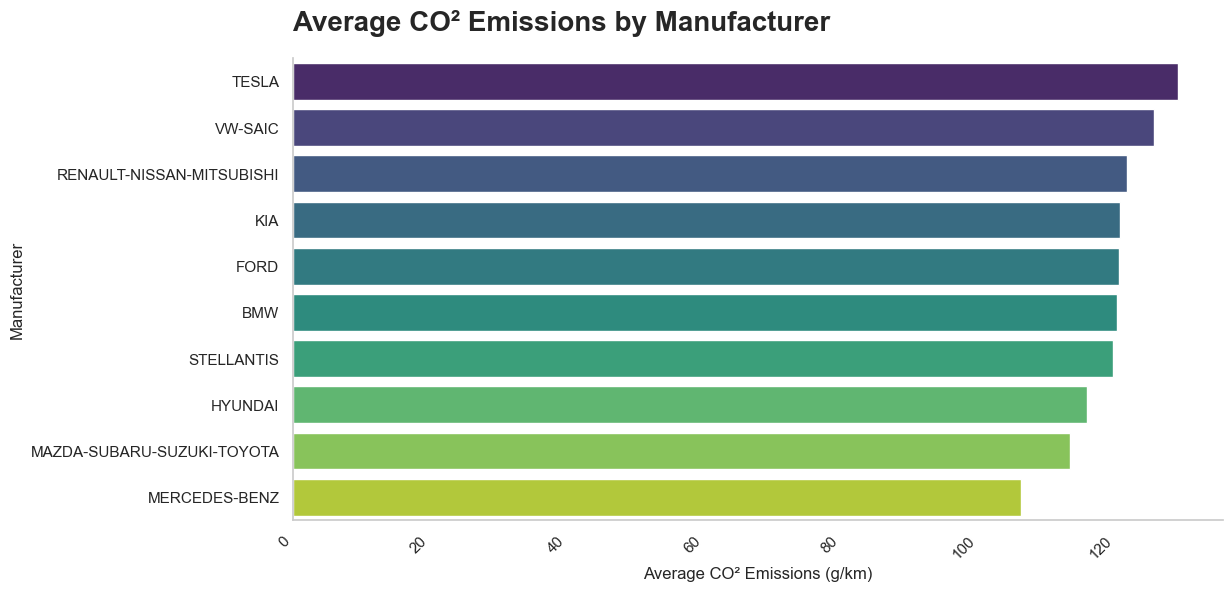


Average CO2 Emissions by Manufacturer:


,Manufacturer,Average CO2 Emissions (g/km)
0,TESLA,129.34
1,VW-SAIC,125.74
2,RENAULT-NISSAN-MITSUBISHI,121.84
3,KIA,120.75
4,FORD,120.69
5,BMW,120.37
6,STELLANTIS,119.86
7,HYUNDAI,115.94
8,MAZDA-SUBARU-SUZUKI-TOYOTA,113.46
9,MERCEDES-BENZ,106.39


In [97]:
# Filtere Kategorien von 'Ft' mit Anzahl 0 aus
filtered_categories = df['Ft'].value_counts()[df['Ft'].value_counts() != 0].index
df_filtered = df[df['Ft'].isin(filtered_categories)]

# Count the number of cars per manufacturer
car_count_by_manufacturer = df_filtered['Mp'].value_counts()

# Barplot for the number of cars per manufacturer
plt.figure(figsize=(12, 6))
sns.barplot(x=car_count_by_manufacturer.values, y=car_count_by_manufacturer.index, order=car_count_by_manufacturer.index, palette='viridis')
plt.title('Car Count by Manufacturer', loc="left", pad=20, fontweight="bold", fontsize=20)
plt.xlabel('Car Count')
plt.ylabel('Manufacturer')
sns.despine(top=True, right=True)
plt.show()

# Table showing the number of cars per manufacturer
car_count_table = pd.DataFrame(car_count_by_manufacturer).reset_index()
car_count_table.columns = ['Manufacturer', 'Car Count']
print("Car Count by Manufacturer:")
display(car_count_table)

# Barplot for average CO2 emissions per manufacturer
average_emissions_by_manufacturer = df_filtered.groupby('Mp')['Ewltp_g/km'].mean().sort_values(ascending=False)

# Barplot for average CO2 emissions
plt.figure(figsize=(12, 6))
sns.barplot(x=average_emissions_by_manufacturer.values, y=average_emissions_by_manufacturer.index, order=average_emissions_by_manufacturer.index, palette='viridis')
plt.title('Average CO² Emissions by Manufacturer', loc="left", pad=20, fontweight="bold", fontsize=20)
plt.xlabel('Average CO² Emissions (g/km)')
plt.ylabel('Manufacturer')
sns.despine(top=True, right=True)
plt.xticks(rotation=45, ha='right')  # Rotate labels on the x-axis
plt.show()

# Table showing average CO2 emissions per manufacturer
average_emissions_table = pd.DataFrame(average_emissions_by_manufacturer).reset_index()
average_emissions_table.columns = ['Manufacturer', 'Average CO2 Emissions (g/km)']
print("\nAverage CO2 Emissions by Manufacturer:")
display(average_emissions_table)



- **'Stellantis'**: With a count of 568,603 cars, Stellantis emerges as the leading manufacturer in terms of dataset representation, holding a significant share.
- **'Renault-Nissan-Mitsubushi':** Following closely, this alliance contributes 407,971 cars, solidifying its presence as a major player in the dataset.
- **'VW-SAIC'**: The manufacturer VW-SAIC holds a substantial but slightly smaller share, with 218,025 cars.
- **'Mazda-Subaru-Suzuki-Toyota':** This group, comprising multiple manufacturers, presents a noteworthy presence with 138,220 cars.
- **'BMW', 'Mercedes-Benz', 'Ford', 'Hyundai', 'Kia':** Each of these manufacturers adds to the dataset with varying car counts, reflecting their individual contributions and market presence.
- **'Tesla'**: While having the smallest count among the listed manufacturers, Tesla still represents a notable portion, contributing 13,553 cars.

The second barplot, depicting the average CO2 emissions by manufacturer, provides valuable insights into the environmental performance of different carmakers. Let's explore the findings:
- **'Tesla':** Notably, Tesla stands out with the highest average CO² emissions of 129.34 g/km, reflecting the unique characteristics of electric vehicles in the dataset.
- **'VW-SAIC', 'Renault-Nissan-Mitsubishi', 'Kia', 'Ford', 'BMW':** These manufacturers exhibit relatively close average CO² emissions, ranging from 120.37 g/km to 125.74 g/km. This suggests a comparable environmental impact across these brands.
- **'Stellantis':** With an average CO² emission of 119.86 g/km, Stellantis positions itself slightly below the mean, contributing to the overall emissions landscape.
- **'Hyundai':** Hyundai follows with an average of 115.94 g/km, indicating a relatively lower environmental impact per kilometer.
- **'Mazda-Subaru-Suzuki-Toyota'**, 'Mercedes-Benz': These manufacturers demonstrate even lower average CO² emissions, with values of 113.46 g/km and 106.39 g/km, respectively. This suggests a stronger commitment to environmental sustainability in their vehicle offerings.


### **CO²-Emissions by Vehicle Category (Cr)**

In the dataset we can differentiate between two types of vehicle categories: 'M1' and 'M1G'. Both classes refer to categories designated by the United Nations Economic Commission for Europe (UNECE) for passenger cars in road traffic. This categorization is aimed at distinguishing various types of vehicles based on their design and use.


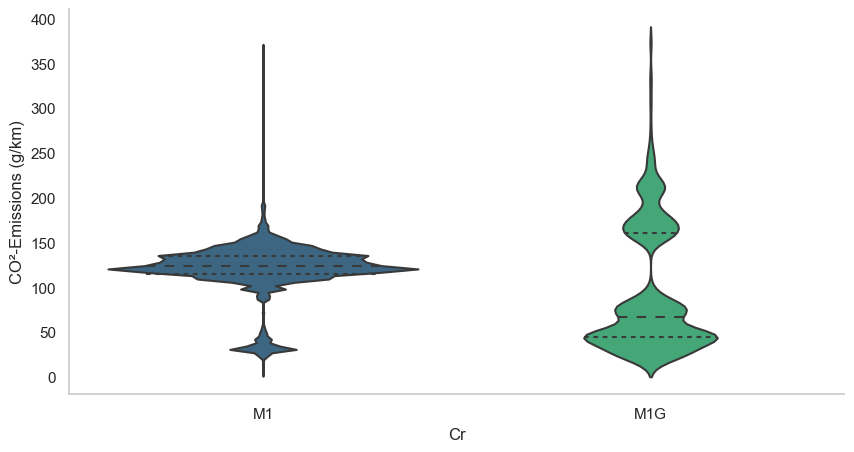

,count,mean,std,min,25%,50%,75%,max
Cr,,,,,,,,
M1,1559146.00,120.73,28.45,4.00,115.00,124.00,135.00,368.00
M1G,30602.00,95.07,70.45,18.00,44.00,67.00,161.00,373.00


In [98]:
# Violinplot für 'Ewltp (g/km)' getrennt nach 'Cr'
plt.figure(figsize=(10, 5))
sns.violinplot(x='Cr', y='Ewltp_g/km', data=df, inner='quartile', palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('Cr')
plt.ylabel('CO²-Emissions (g/km)')
sns.despine(top=True, right=True)
plt.show()

# Descriptive statistics by 'Cr'
descriptive_stats_by_cr = df.groupby('Cr')['Ewltp_g/km'].describe()

# Display the descriptive statistics
display(descriptive_stats_by_cr)


- **'M1':** This category includes passenger cars designed and constructed for the transportation of passengers. It encompasses the majority of conventional cars intended for the individual transportation of people on public roads.
- **'M1G':** This category pertains to passenger cars that, in addition to transporting passengers, can also be used for the transportation of goods. Typically, these are vehicles with a specialized design capable of carrying both passengers and cargo. In the dataset only 1.9% of all registered vehicles belong to this category.

Purpose of the categorization is to facilitate the differentiation of vehicle types in various traffic statistics and regulations, as they cater to different characteristics and purposes.

The **violinplot for the 'Cr'** variable, categorized into 'M1' (passenger cars for individuals) and 'M1G' (dual-purpose passenger and goods transport) categories, reveals distinct patterns in the distribution of CO² emissions for these vehicle.. In the case of M1 vehicles, designed primarily for individual transportation, the violinplot indicates a relatively tight and concentrated distribution around the median. The mean emissions are approximately 120.73 g/km, with a moderate spread. The distribution spans from 4 g/km to 368 g/km, reflecting a typical range for passenger cars.

On the other hand, M1G vehicles, designed for both passenger and goods transport, exhibit a broader distribution with higher variability. The mean emissions are lower at around 95.07 g/km, but the wider spread suggests a more diverse range of CO² emissions. Notably, there are outliers on the right side of the distribution, indicating some M1G vehicles with significantly higher emissions levels. The distribution for M1G vehicles spans from 18 g/km to 373 g/km.

In summary, the violinplot highlights the distinct emissions characteristics of M1 and M1G vehicle classes, aligning with their intended purposes. 


### **Fuel Mode (Fm)**

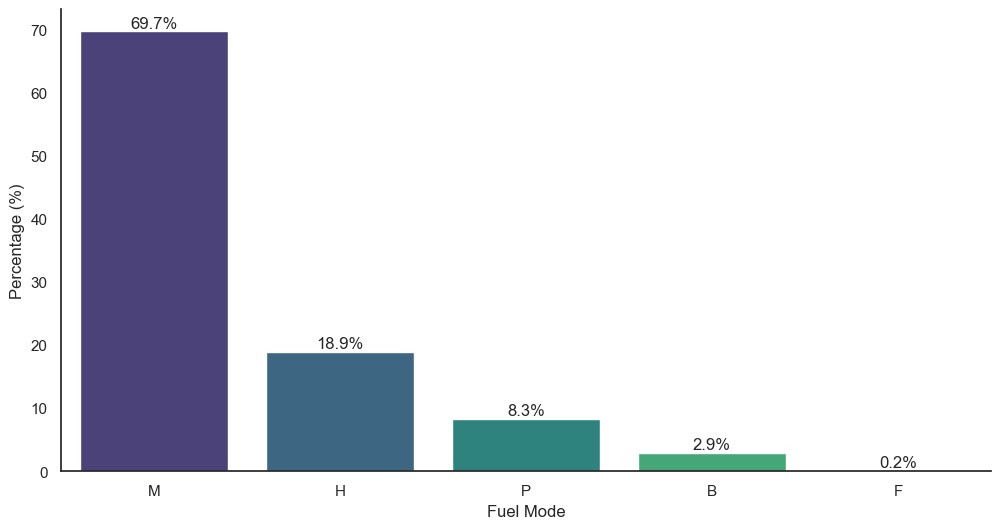

Fm,B,F,H,M,P
count,46408.00,2454.00,300696.00,1107939.00,132251.00
mean,115.52,125.71,121.65,129.92,37.39
std,6.44,3.08,21.37,15.35,12.33
min,106.00,119.00,85.00,101.00,4.00
25%,109.00,126.00,109.00,120.00,31.00
50%,115.00,127.00,120.00,127.00,32.00
75%,115.00,127.00,132.00,138.00,42.00
max,163.00,143.00,320.00,373.00,160.00


In [99]:
# Convert 'Fm' to string
df['Fm'] = df['Fm'].astype(str)

# Remove rows where 'Fm' has the value 'E'
df_filtered = df[df['Fm'] != 'E']

# Function to convert absolute values to percentages
def absolute_to_percentage(absolute_values):
    total = sum(absolute_values)
    return [value / total * 100 for value in absolute_values]

# Sort by size
fm_counts = df['Fm'].value_counts().sort_values(ascending=False)

# Set the style to 'whitegrid' to remove the grid lines
sns.set_style("white")

# Barplot for 'Fm' in percentage
plt.figure(figsize=(12, 6))
fm_percentage = absolute_to_percentage(fm_counts)
sns.barplot(x=fm_counts.index, y=fm_percentage, palette='viridis', order=fm_counts.index)
plt.title('', loc="left", pad=20, fontweight="bold", fontsize=16)
plt.xlabel('Fuel Mode')
plt.ylabel('Percentage (%)')
sns.despine(top=True, right=True, left=False, bottom=False)

# Display percentages in the barplot
for i, value in enumerate(fm_counts):
    plt.text(i, fm_percentage[i] + 0.5, f'{fm_percentage[i]:.1f}%', ha='center')

plt.show()

# Group the DataFrame by 'Fm' ('Fuel Mode') and obtain descriptive statistics
summary_by_fuel_type = df_filtered.groupby('Fm')['Ewltp_g/km'].describe().T

# Filter out categories with Count=0
summary_by_fuel_mode_filtered = summary_by_fuel_type.loc[:, summary_by_fuel_type.loc['count'] > 0]

display(summary_by_fuel_mode_filtered)


**Description Barpolot**

- **Monofuel ('M'):** This is the predominant fuel mode in the dataset, representing 69.7% of the vehicles. Monofuel vehicles operate solely on a single fuel type, such as gasoline, diesel, autogas, natural gas, or hydrogen.
- **Hybrid without External Charging ('H'):** Hybrid vehicles without the ability to charge externally account for 18.9% of the dataset. These vehicles rely on a combination of an internal combustion engine and an electric motor but cannot charge their batteries externally.
- **Plug-in Hybrid Electric Vehicles ('P'):** Plug-in hybrid electric vehicles, which can charge externally, make up 8.3% of the dataset. These vehicles have both an internal combustion engine and a battery that can be charged via an external power source.
- **Bifuel ('B'):** Bifuel vehicles, capable of running on two separate fuel types, represent 2.9% of the dataset. These vehicles are designed to primarily operate on one fuel type but can switch to another.
- **Flex-Fuel ('F'):** Flex-Fuel vehicles, capable of running on various fuel mixtures, have the lowest representation at 0.2% in the dataset. These vehicles typically operate on a mixture of gasoline and ethanol.


### **Fuel Types (Ft**)

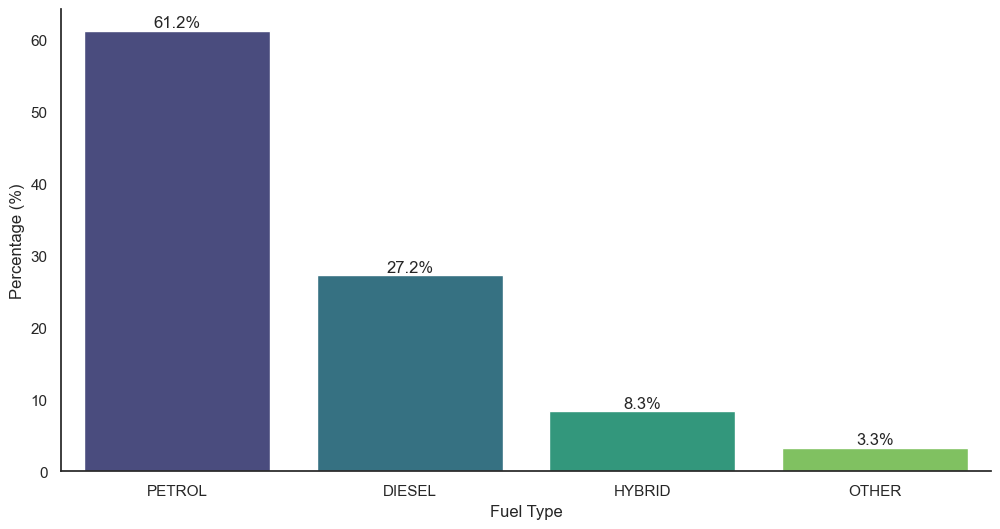

Ft,DIESEL,HYBRID,OTHER,PETROL
count,432688.00,132251.00,52378.00,972431.00
mean,131.00,37.39,119.85,126.73
std,17.44,12.33,19.61,16.45
min,101.00,4.00,106.00,85.00
25%,120.00,31.00,109.00,118.00
50%,130.00,32.00,115.00,125.00
75%,140.00,42.00,120.00,135.00
max,285.00,160.00,228.00,373.00


In [100]:
# Filter categories of 'Ft' with count greater than 0
filtered_categories = df['Ft'].value_counts()[df['Ft'].value_counts() != 0].index
df_filtered = df[df['Ft'].isin(filtered_categories)]

# Define the desired order of categories
desired_categories_order = ['DIESEL', 'OTHER', 'PETROL', 'HYBRID']

ft_counts = df['Ft'].value_counts()[desired_categories_order].sort_values(ascending=False)

# Set the style to 'whitegrid' to remove the grid lines
sns.set_style("white")

# Barplot for 'Ft' in percentage
plt.figure(figsize=(12, 6))
ft_percentage = absolute_to_percentage(ft_counts)
sns.barplot(x=ft_counts.index, y=ft_percentage, palette='viridis', order=ft_counts.index)
plt.title('', loc="left", pad=20, fontweight="bold", fontsize=16)
plt.xlabel('Fuel Type')
plt.ylabel('Percentage (%)')
sns.despine(top=True, right=True, left=False, bottom=False)

# Display percentages on the Barplot
for i, value in enumerate(ft_counts):
    plt.text(i, ft_percentage[i] + 0.5, f'{ft_percentage[i]:.1f}%', ha='center')

plt.show()

# Set Pandas display options to show floating-point numbers with two decimal places
pd.set_option('display.float_format', '{:.2f}'.format)

# Group the DataFrame by 'Ft' ('Fuel Type') and obtain descriptive statistics
summary_by_fuel_type = df_filtered.groupby('Ft')['Ewltp_g/km'].describe().T

# Filter out categories with Count=0
summary_by_fuel_type_filtered = summary_by_fuel_type.loc[:, summary_by_fuel_type.loc['count'] > 0]

display(summary_by_fuel_type_filtered)





**Description Barplot**

- **'Petrol'**: Petrol-fueled vehicles dominate the dataset, constituting 61.2% of the total. These vehicles rely on gasoline as their primary fuel source.
- **'Diesel':** Diesel-fueled vehicles represent 27.2% of the dataset. Diesel engines are known for their fuel efficiency and are commonly used in various vehicle types.
- **'Hybrid':** Hybrid vehicles, combining an internal combustion engine with an electric motor, make up 8.3% of the dataset. These vehicles can operate on both conventional fuel and electric power.
- **'Other':** The category labeled as 'Other' encompasses 3.3% of the dataset. This may include vehicles using alternative fuels or those with unique fuel characteristics not falling into the Petrol, Diesel, or Hybrid categories.


### **CO²-Emissions (Ewltp (g/km))**

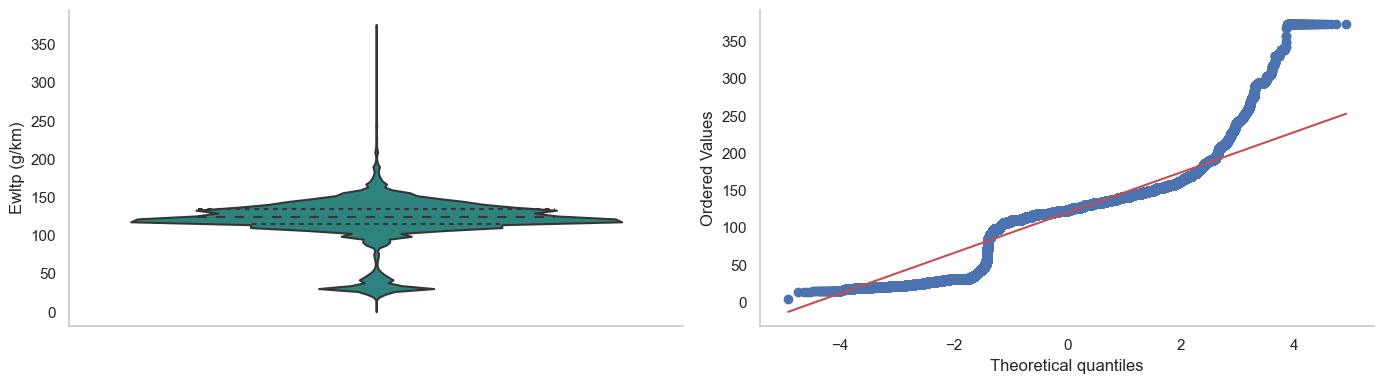

In [101]:
from scipy.stats import probplot

# Set the style for Seaborn
sns.set(style="whitegrid")

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="Ewltp_g/km", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Ewltp (g/km)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['Ewltp_g/km'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The **violinplot for CO² emissions** measured with the WLTP testing procedure ('Ewltp_g/km') depicts a positively skewed distribution, showcasing a wider upper part. This implies that higher CO² emissions per kilometer are less common, with the median at approximately 124. This observation is further supported by key statistical measures including a mean of around 120.23 g/km and a moderate spread of 30.03 g/km around this mean (standard deviation). An additional noteworthy observation is the presence of an apparent mode around 50  (g/km). This distinct mode indicates a concentration of vehicles with emissions centered around this value, contributing to a notable peak in the distribution. 

The violinplot suggests a dual nature in the distribution, with a concentration of vehicles exhibiting moderate emissions around the median and a notable mode around 50 g/km.

The **QQ-plot** indicates a flattening of the empirical distribution in the lower quantiles, suggesting that lower values of CO² emissions per kilometer are less pronounced than expected in a perfect normal distribution. Conversely, a steeper rise in the upper quantiles suggests that higher values are more pronounced than predicted by a normal distribution. These deviations highlight that the distribution of CO² emissions per kilometer doesn't perfectly align with normality, indicating potential skewness, tails, or outliers influencing the distribution.


### **Fuel Consumption (Fc)**

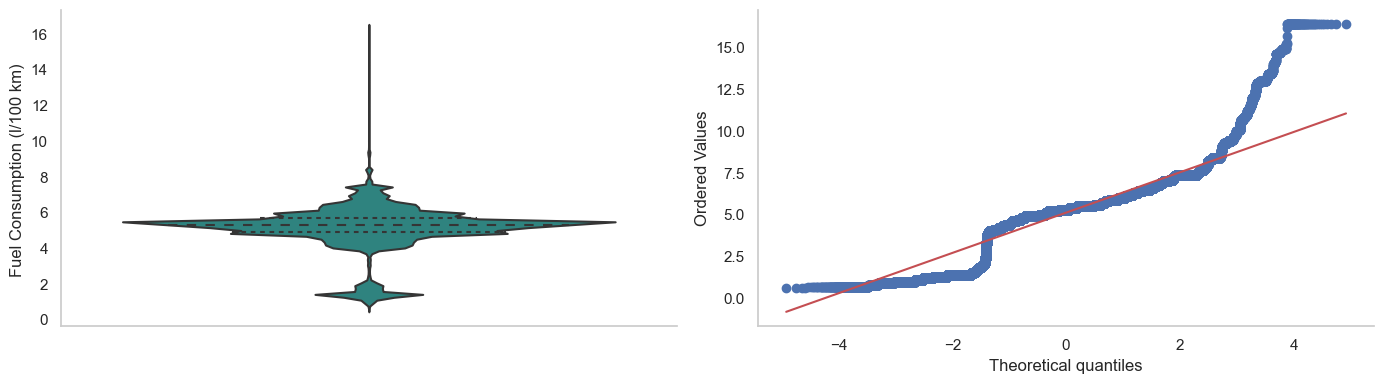

In [102]:
# Set style to whitegrid
sns.set(style="whitegrid")

# Erstelle ein 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="Fc", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Fuel Consumption (l/100 km) ')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['Fc'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The **violinplot for fuel consumption ('Fc')** displays a positively skewed distribution similar to the pattern observed for 'Ewltp_g/km'. The wider upper part suggests that higher fuel consumption values per kilometer are less common, with the median at approximately 5.13 L/100 km. The statistical summary confirms this, indicating a mean of around 4.69 L/100 km and a moderate spread around this mean (standard deviation of approximately 15.84 L/100 km). However, a notable and distinct mode is observed a fuel consumption around 2 L/100 km. This mode indicates a concentration of vehicles with fuel consumption centered around this specific value, contributing to a prominent peak in the distribution. The violinplot suggests a dual nature in the distribution, with a concentration of vehicles exhibiting moderate fuel consumption around the median and a significant mode around 2 L/100 km.

Similar to the CO² emissions per kilometer **QQ plot**, this indicates a flattening of the empirical distribution in the lower quantiles, suggesting that lower values of fuel consumption are less pronounced than expected in a perfect normal distribution. Conversely, a steeper rise in the upper quantiles suggests that higher values of fuel consumption are more pronounced than predicted by a normal distribution.

These deviations highlight that the distribution of fuel consumption doesn't perfectly align with normality, indicating potential skewness, tails, or outliers influencing the distribution. The presence of a distinct mode around 50 L/100 km in the violinplot adds an interesting dimension to the distribution, suggesting a concentration of vehicles with specific fuel consumption values that deviate from the overall trend. Further investigation into the characteristics of vehicles contributing to this mode may provide valuable insights.


### **Vehicle width ('W_mm') and steering axle width ('At1_mm')**

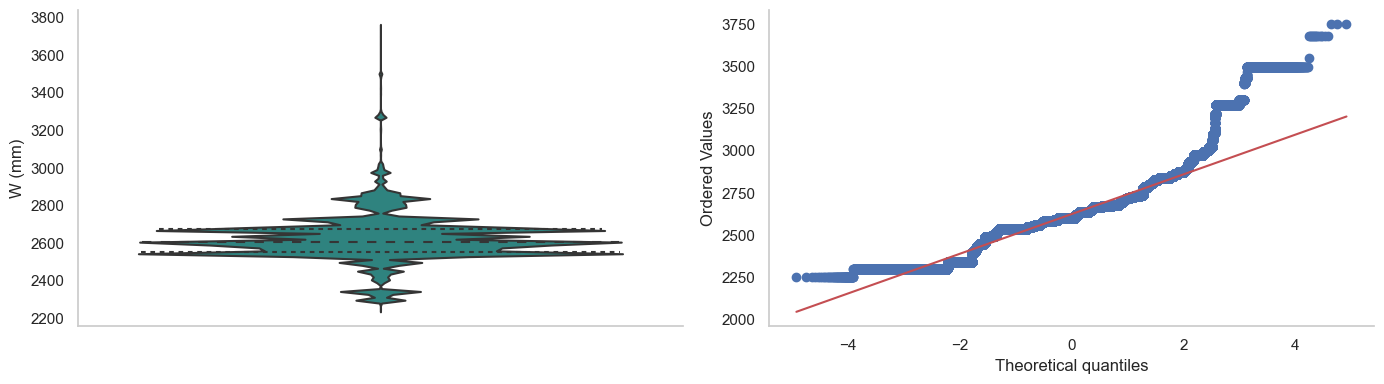

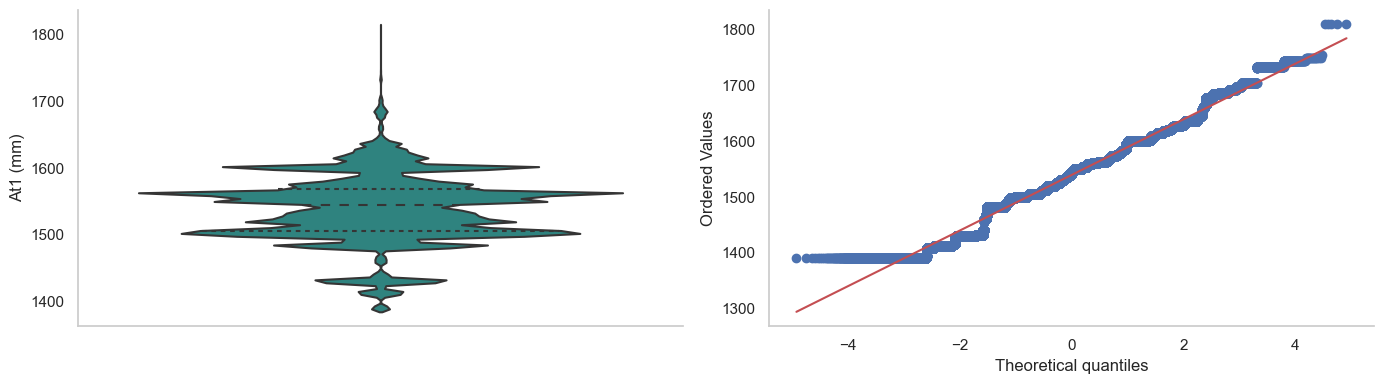

In [103]:
# Set style to whitegrid
sns.set(style="whitegrid")

# Create 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="W_mm", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('W (mm)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['W_mm'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Setze den Stil für Seaborn
sns.set(style="whitegrid")

# Erstelle ein 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="At1_mm", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('At1 (mm)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['At1_mm'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()



Transitioning from the insights gained from the analysis of 'Ewltp_g/km', we delve into the characteristics of two additional variables, 'W_mm' and 'At1_mm'.

The **violinplot for 'W_mm'** presents a distinctive pattern with numerous spikes, suggesting inherent variability in the data. This jagged appearance implies certain values or ranges are more prevalent, contributing to the irregular shape. Notably, the upper part of the distribution appears more pronounced, indicating a less frequent occurrence of higher values. Examining the statistical summary, we find a mean of approximately 2625.14 mm, a median around 2605 mm, and a moderate spread indicated by a standard deviation of roughly 123.44 mm.

Similarly, the **violinplot for 'At1_mm'** exhibits a complex structure with spikes, indicative of specific data patterns The distribution highlights a more pronounced upper portion, suggesting that higher values are less common. Key statistical measures reinforce this, revealing a mean of approximately 1539.53 mm, a median around 1544 mm, and a moderate spread with a standard deviation of about 50.41.
Both 'W_mm' and 'At1_mm' violinplots depict intricate structures, emphasizing the existence of certain data patterns or modes. The statistical summaries provide insights into the central tendency and variability of each variable. Notably, the pronounced upper portions of the violinplots suggest that higher values are less prevalent.

Examining the broader context, the descriptive statistics underscore the distributional characteristics. 'W_mm' spans from a minimum of 2250 mm to a maximum of 3750 mm, while 'At1_mm' ranges from 1390 mm to 1810 mm. These ranges align with the violinplots emphasis on specific value ranges. Both QQ plots deviate from the expected line, notably from the lower  fourth quantile onward, indicating a departure from a perfectly normal distribution. 

The diverse structure of the violinplots for width ('W_mm') and front axle distance ('At1_mm') reflects the fundamental logic and diversity within the vehicle data. The variations in widths and front axle distances are not uncommon and can be explained by the inclusion of vehicles from different manufacturers and models in the dataset.
Vehicles from various manufacturers and models inherently exhibit distinct geometric dimensions, especially concerning width and the distance between front axles. The multitude of spikes in the violinplots suggests that specific values or ranges in these dimensions are more prevalent.

The 8-value summary supports this context by presenting average values, standard deviations, and extreme values for 'W_mm' and 'At1_mm'. These variations are not only explainable but also expected when diverse vehicle types are represented in the data.

Identifying and interpreting these differences in geometric dimensions contribute to understanding the diversity of vehicles in the dataset. This understanding is crucial for exploring specific patterns and features that may impact CO² emissions or other performance factors.


### **Vehicle Weight (m (kg))**

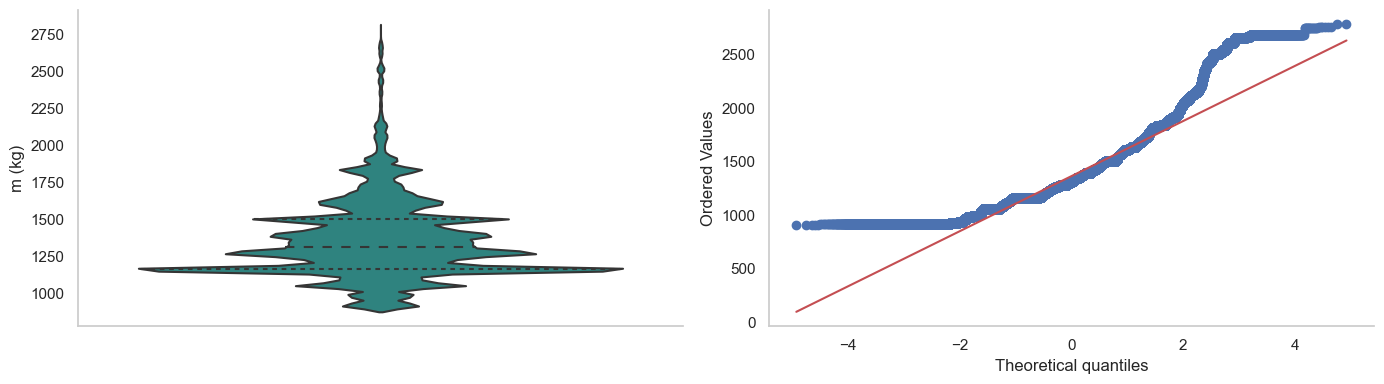

In [104]:
# Setze den Stil für Seaborn
sns.set(style="whitegrid")

# Erstelle ein 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="m_kg", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('m (kg)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['m_kg'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The **violin plot for 'm_kg' (vehicle weight)** reveals a fascinating distribution characterized by multiple spikes, indicating distinct concentrations of vehicles within specific weight ranges. The statistical summary enhances our understanding, providing key metrics such as the mean, standard deviation, and extreme values for 'm_kg'. The presence of multiple spikes suggests that certain weight categories are more prevalent, contributing to the multimodal nature of the distribution. The mean weight is approximately 1364.92 kg, with a moderate spread indicated by the standard deviation of around 268.08 kg. The complexity in the distribution is further emphasized by the minimum and maximum values of 910 kg and 2785 kg, respectively.

The **QQ plot for 'm_kg'** provides additional insights into the distribution, displaying deviations starting from the -lower second quantile below and the upper second quantile above the normal distribution line . These deviations suggest that the distribution of vehicle weights deviates from a perfect normal distribution. The plot indicates a steeper rise in the upper quantiles, implying that higher values of vehicle weight are more pronounced than expected in a normal distribution. The summary statistics and QQ plot align, emphasizing the non-normal characteristics of the distribution, particularly with an upward shift at the lower and upper second quantiles.

In summary, the violinplot and QQ plot unveil a complex distribution of vehicle weights, with multiple spikes indicating distinct weight categories. The key statistical measures provide a numerical backdrop, highlighting the variability and concentration of weights within the dataset. This multimodal distribution suggests that vehicles in the dataset fall into diverse weight clusters, prompting further exploration into the factors influencing these weight categories and their potential implications for other variables in the dataset.


### **Engine capacities ('ec_cm3') and engine power (‘ep (kW)’)**

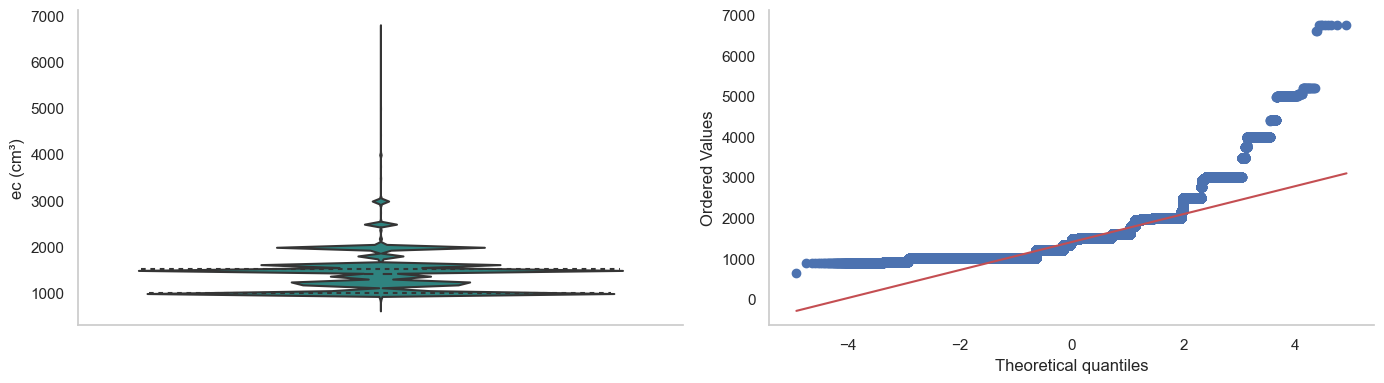

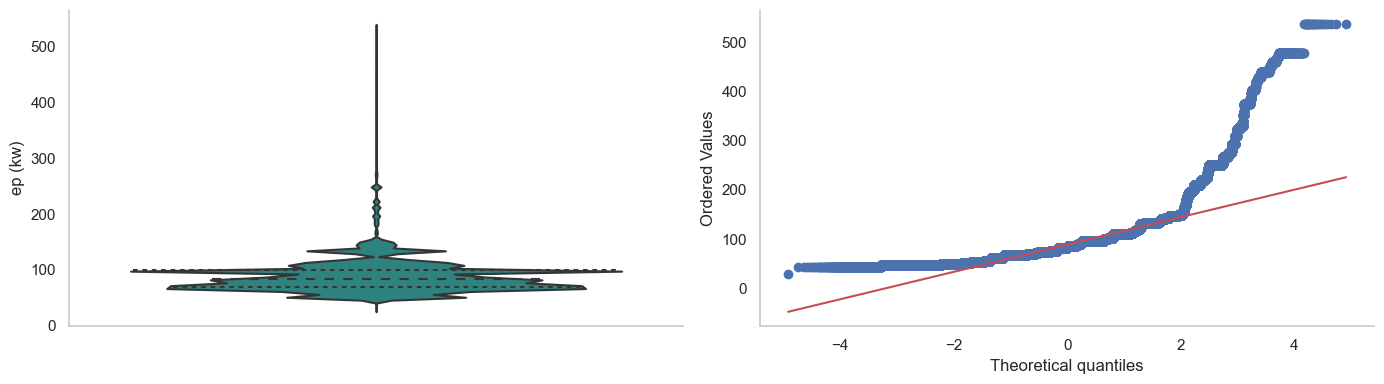

In [105]:
# Setze den Stil für Seaborn
sns.set(style="whitegrid")

# Erstelle ein 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="ec_cm3", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('ec (cm³)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['ec_cm3'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Setze den Stil für Seaborn
sns.set(style="whitegrid")

# Erstelle ein 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="ep_KW", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('ep (kw)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['ep_KW'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()



Moving on to the variables engine capacity in cubic centimeters ('ec_cm3') and engine power in kilowatts 'ep_KW', the violinplots reveal interesting patterns in the distribution of these engine-related features.

The **violinplot for 'ec_cm3'** showcases a distribution marked by multiple spikes, suggesting the presence of distinct concentrations of engine capacities. This variability is supported by the summary statistics, which provide the mean, standard deviation, and extreme values for 'ec_cm3'. The mean engine capacity is approximately 1396.17 cm³, with a standard deviation of around 372.97, indicating moderate variability. The violinplot’s spikes indicate that certain engine capacities are more prevalent, contributing to the overall shape of the distribution.

The **violinplot for 'ep_KW'** reveals a distribution with pronounced variability in engine power. Similar to 'ec_cm3', the plot displays multiple spikes, indicating concentrations of specific power values. The statistical summary provides context, showing a mean power of approximately 89.01 kW, with a standard deviation of about 31.13. The presence of spikes suggests that certain power values are more prevalent within the dataset. 

The **QQ plots for both 'ec_cm3' and 'ep_KW'** display deviations from normality, with an upward shift at the lower and upper second quantiles. These deviations indicate that the distributions of engine capacity and power deviate from a perfect normal distribution. The descriptive statistics and QQ plots collectively highlight the non-normal characteristics of these engine-related features.

In summary, the violin plots and QQ plots for 'ec_cm3' and 'ep_KW' unveil intricate distributions with multiple spikes, suggesting concentrations of specific engine capacities and power values. The summary statistics provide numerical insights into the variability and central tendencies of these engine-related features, paving the way for further exploration into the factors influencing these concentrations within the dataset.


### **Electric range ('Er_km')**

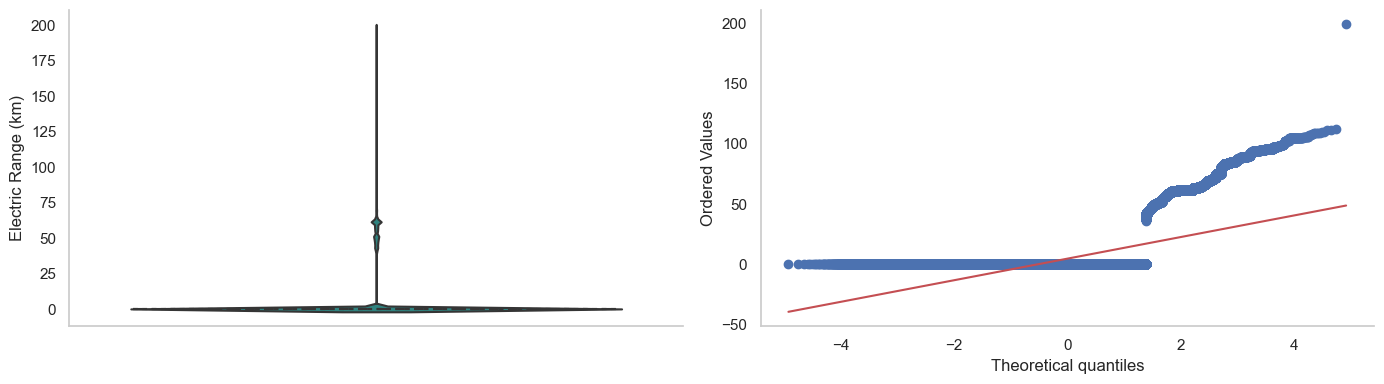

In [106]:
# Set style to whitegrid
sns.set(style="whitegrid")

# Create 1x2 Subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="Er_km", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Electric Range (km)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['Er_km'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The **violin plot for 'Er_km'** reveals a distinctive and intriguing pattern characterized by a flattened shape. This suggests that a significant portion of vehicles in the dataset appears to have no electric range or very limited electric range. The absence of a well-defined peak and the flatness of the plot indicate a concentration of vehicles with minimal or zero electric range.

The **QQ-plot for 'Er_km'** further supports this observation by displaying a horizontal line for observed values from the lower fourth and upper second quantile. This suggests a consistent distribution of observed values within this range, indicating that a substantial proportion of the dataset lacks electric range. Beyond the -4th quantile, the plot shows an upward shift, indicating that the observed values have a higher frequency than expected in a normal distribution. This suggests that vehicles with electric range values, although limited, are more prevalent than predicted by a normal distribution.

In summary, the flattened shape of the violin plot and the consistent horizontal line in the QQ-plot for the observed values from lower fourth and upper second quantile indicate a notable concentration of vehicles with little to no electric range. The subsequent upward shift in the QQ-plot suggests that the limited electric range values present in the dataset are more common than expected in a normal distribution. Further investigation into the characteristics of these vehicles and potential factors influencing their electric range is warranted.


### **Energy Consumption (z (Wh/km))**


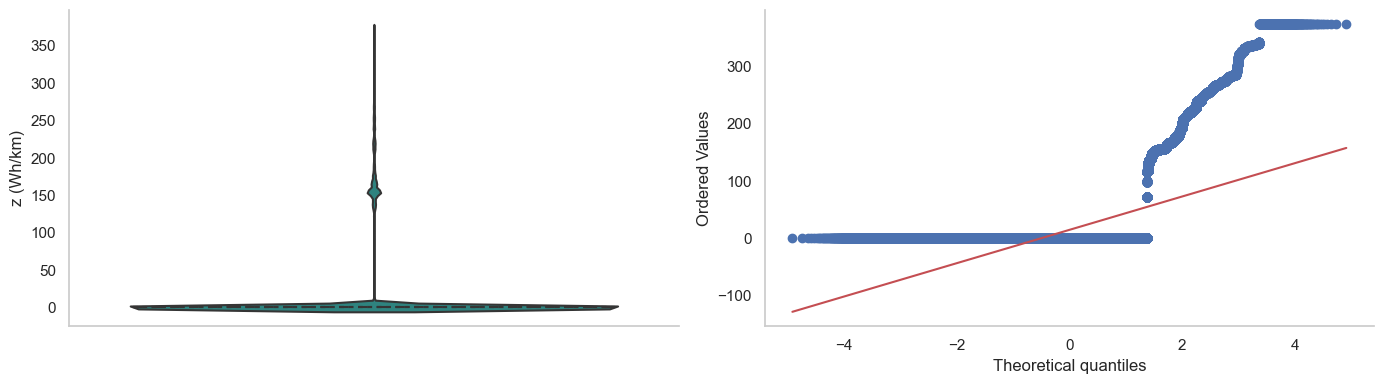

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Set the style for Seaborn
sns.set(style="whitegrid")

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="z_Wh/km", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('z (Wh/km)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['z_Wh/km'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The **violin plot for energy consumption per kilometer ('z_Wh/km')** appears similar to the pattern observed in the Electric Range variable. It exhibits a flattened shape, suggesting that a substantial number of vehicles in the dataset have minimal or zero energy consumption per kilometer. The absence of a well-defined peak and the flatness of the plot indicate a concentration of vehicles with low energy consumption or no consumption at all.

The **QQ-plot for 'z_Wh/km'** supports this observation, displaying a horizontal line for observed values from the -lower fourth and upper second quantile. This consistent distribution of observed values within this range suggests that a significant proportion of the dataset exhibits minimal energy consumption. Beyond the fourth quantile, the plot shows an upward shift, indicating that the observed values with energy consumption are more prevalent than expected in a normal distribution. 

The similarities between the violin plot and QQ-plot for 'z_Wh/km' and the Electric Range variable suggest a commonality in the distribution patterns of these two variables. The flattened shape and the consistent horizontal line in the QQ-plot indicate a concentration of vehicles with low or no energy consumption per kilometer. The subsequent upward shift suggests that, although limited, energy consumption values are more common than expected in a normal distribution.
In summary, the patterns observed in the violin plot and QQ plot for 'z_Wh/km' indicate a significant presence of vehicles with minimal energy consumption or no consumption per kilometer. Further exploration into the characteristics of these vehicles and the factors influencing their energy consumption is warranted.


### **Emissions Reduction through Innovative Technologies (Erwltp (g/km))**

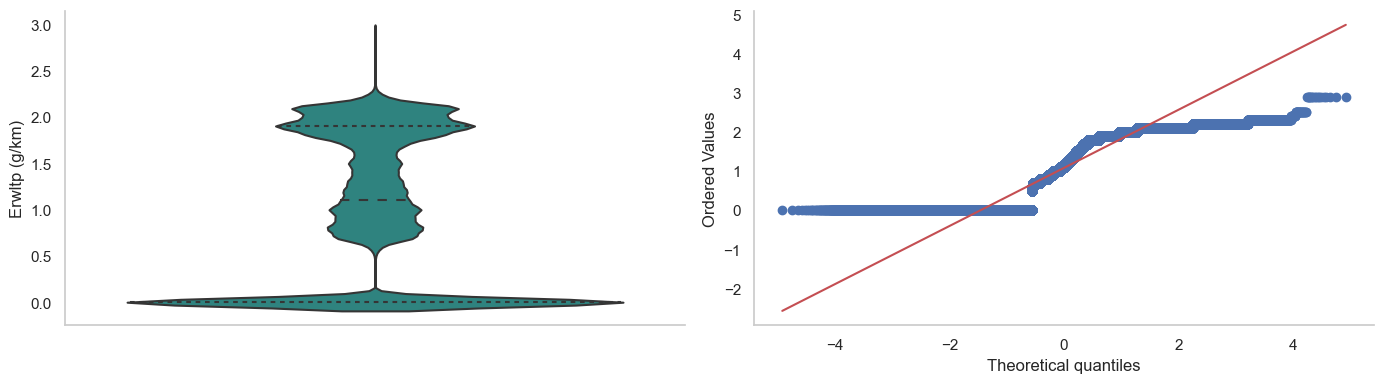

In [108]:
# Set the style for Seaborn
sns.set(style="whitegrid")

# Create a 1x2 subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Violinplot
sns.violinplot(y="Erwltp_g/km", data=df_filtered, inner='quartile', palette='viridis', ax=axes[0])
axes[0].set_title('')
axes[0].set_xlabel('')
axes[0].set_ylabel('Erwltp (g/km)')
axes[0].grid(False)

sns.despine(ax=axes[0], top=True, right=True)

# QQ-Plot
probplot(df_filtered['Erwltp_g/km'], dist='norm', plot=axes[1])
axes[1].set_title('')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].grid(False)

plt.tight_layout()
plt.show()


The variable 'Erwltp_g/km' stands for "Emissions reduction through innovative technologies per kilometer" and measures a vehicle's CO2 emission reductions achieved through innovative technologies. It indicates how effectively a vehicle reduces CO2 emissions per kilometer through advanced technologies and environmental innovations, expressed in grams per kilometer (g/km). A higher value signifies greater effectiveness in reducing CO2 emissions for each kilometer traveled. As a result, this variable is relevant for assessing the environmental impact and sustainability of vehicles.

The **violin plot for 'Erwltp_g/km'** unveils a distribution with multiple modes, notably a significant mode around 0 g/km. This indicates a concentration of vehicles with minimal or no reported CO2 emission reductions through environmental innovations. The width of the plot around 0 g/km signifies a substantial number of vehicles falling into this category. Additionally, other modes may suggest variations in the effectiveness of environmental technologies across different vehicles.
 
The **statistical summary** aligns with these observations, indicating that the mean is around 1.08 g/km, and the median (50th percentile) is 1.10 g/km. The standard deviation of approximately 0.80 implies a moderate spread around the mean. Notably, the 25th percentile is 0.00 g/km, emphasizing the prevalence of vehicles with reported emission reductions close to zero.

The **QQ plot for 'Erwltp_g/km'** corroborates the findings from the violin plot. A horizontal line is observed from approximately -4 to 0 on the quantile scale, indicating a consistent empirical distribution in this range. Beyond the 0 quantile, the line deviates below the expected normal distribution, suggesting that the observed values have a lower frequency than what a normal distribution would predict. This is consistent with the concentration of vehicles around 0 in the violin plot.

These combined insights from the violin plot, QQ plot, and descriptive statistics underscore that a significant proportion of vehicles in the dataset exhibit minimal or no reported CO2 emission reductions as captured by 'Erwltp_g/km'. The multiple modes in the distribution indicate potential diversity in the effectiveness of environmental innovations across different vehicles. The statistical summary provides quantitative measures that support and complement the visual observations, offering a comprehensive understanding of the dataset’s characteristics related to emissions reductions.



## **Multivariate Analysis**

Following the univariate analysis, our trajectory leads us to the realm of multivariate analysis. This advanced analytical approach delves into the interdependencies and relationships among multiple variables within our dataset. Multivariate analysis enables us to unravel complex patterns, correlations, and interactions that may not be apparent in isolation. By exploring the collective impact of multiple variables, we aim to gain a more holistic understanding of the intricate dynamics within our data. This phase of analysis will pave the way for nuanced insights and informed decision-making in our broader statistical exploration.

### **Correlation of numerical variables**

Correlation analysis is a powerful statistical method that allows for the identification and quantification of relationships between variables. By exploring correlations, researchers and data analysts gain valuable insights to understand patterns, associations, and trends within a dataset. This analytical technique is crucial in exploratory data analysis (EDA) and supports the derivation of hypotheses regarding potential causes and effects.
At its core, correlation analysis measures the strength and direction of linear relationships between variables. The most commonly used correlation coefficient, the Pearson correlation coefficient, ranges from -1 to 1. A value of 1 indicates a perfect positive linear relationship, -1 indicates a perfect negative relationship, and 0 indicates no linear relationship. However, it’s essential to emphasize that correlation does not imply causation; a high correlation between two variables does not necessarily mean that one variable causes the other.
Correlation analysis allows for the identification of patterns of behavior, dependencies, and independencies between variables. It is applied across various disciplines such as economics, medicine, psychology, and environmental sciences to understand relationships and make informed decisions.



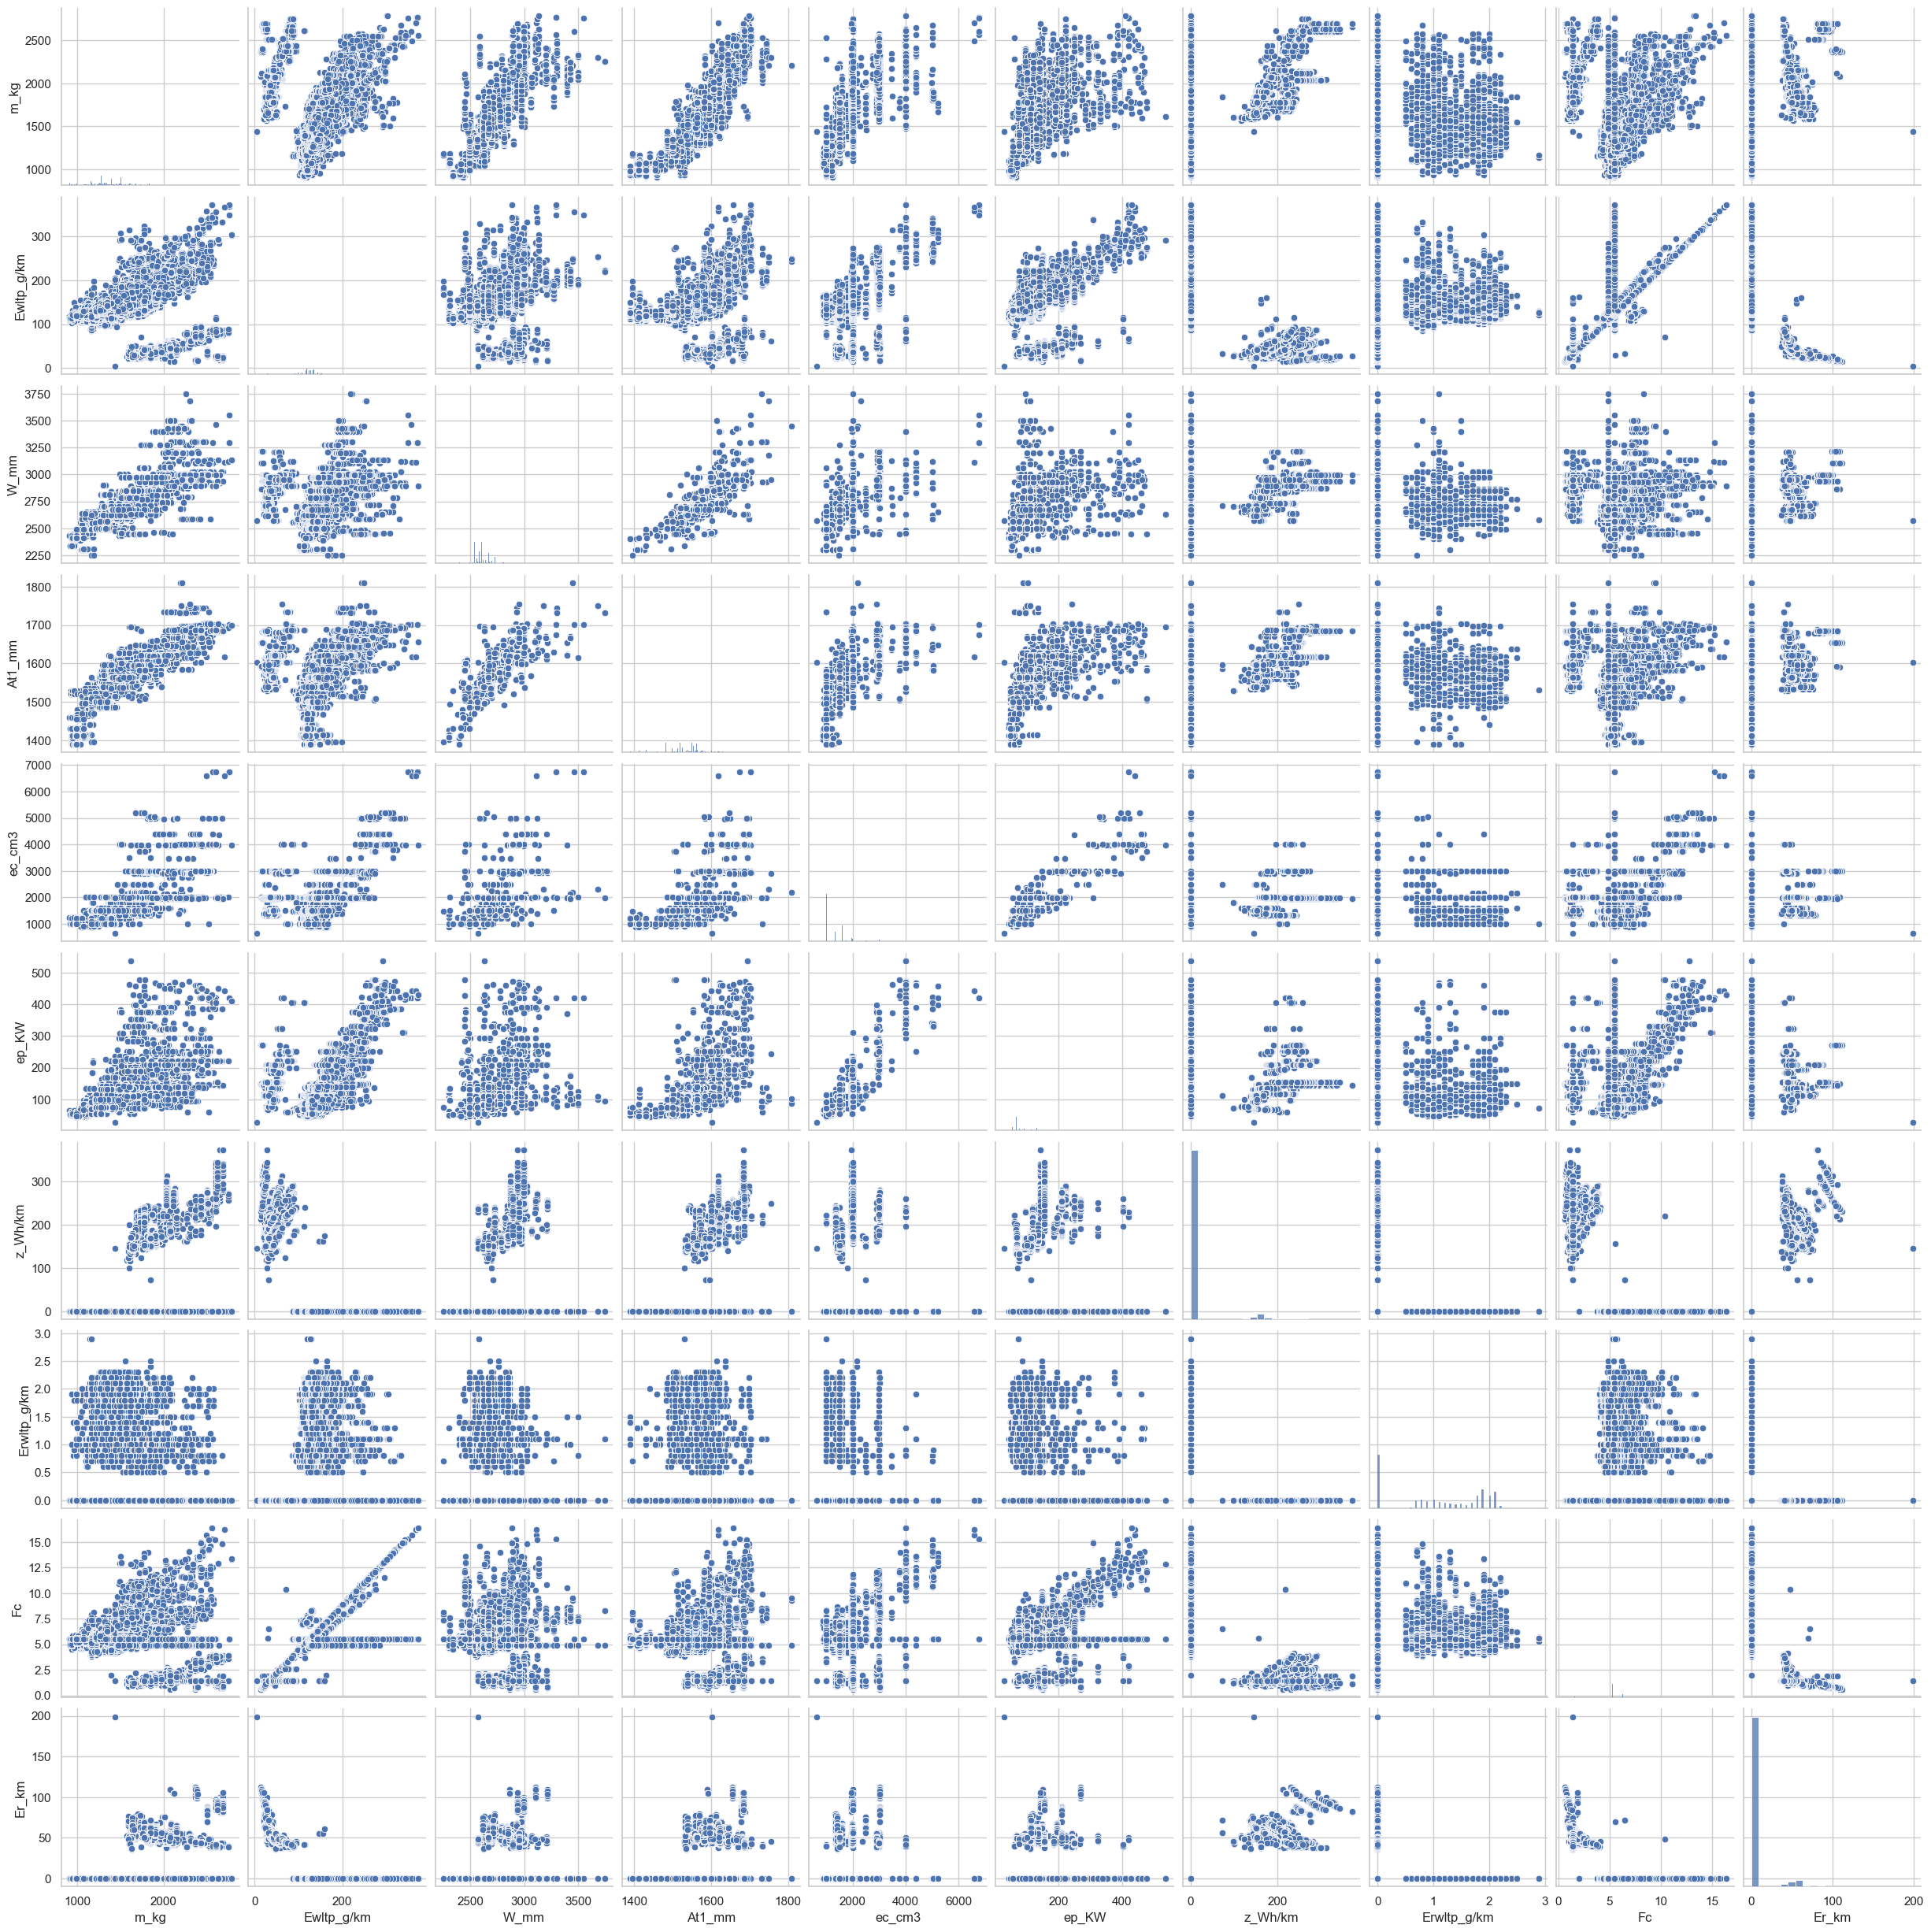

In [109]:
# Define subset
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Create pairplot
sns.pairplot(numeric_df)
plt.suptitle("", y=1.02, fontweight="bold")
plt.show()

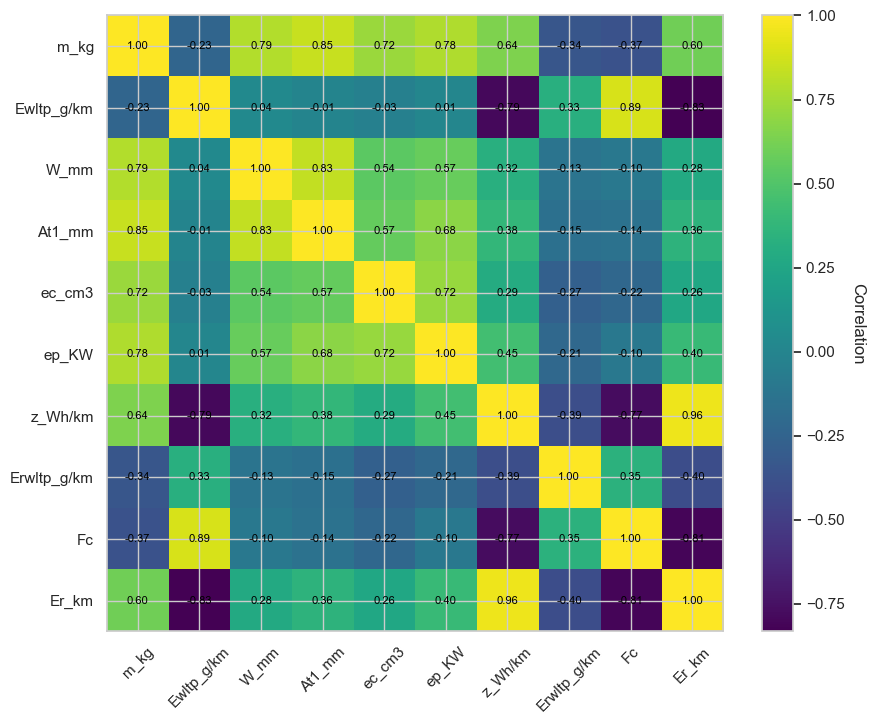

,m_kg,Ewltp_g/km,W_mm,At1_mm,ec_cm3,ep_KW,z_Wh/km,Erwltp_g/km,Fc,Er_km
m_kg,1.00,-0.23,0.79,0.85,0.72,0.78,0.64,-0.34,-0.37,0.60
Ewltp_g/km,-0.23,1.00,0.04,-0.01,-0.03,0.01,-0.79,0.33,0.89,-0.83
W_mm,0.79,0.04,1.00,0.83,0.54,0.57,0.32,-0.13,-0.10,0.28
At1_mm,0.85,-0.01,0.83,1.00,0.57,0.68,0.38,-0.15,-0.14,0.36
ec_cm3,0.72,-0.03,0.54,0.57,1.00,0.72,0.29,-0.27,-0.22,0.26
ep_KW,0.78,0.01,0.57,0.68,0.72,1.00,0.45,-0.21,-0.10,0.40
z_Wh/km,0.64,-0.79,0.32,0.38,0.29,0.45,1.00,-0.39,-0.77,0.96
Erwltp_g/km,-0.34,0.33,-0.13,-0.15,-0.27,-0.21,-0.39,1.00,0.35,-0.40
Fc,-0.37,0.89,-0.10,-0.14,-0.22,-0.10,-0.77,0.35,1.00,-0.81
Er_km,0.60,-0.83,0.28,0.36,0.26,0.40,0.96,-0.40,-0.81,1.00


In [110]:
# Create a subset of the dataframe with only numerical variables
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Create a heatmap using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest')

# Display colorbar
cbar = plt.colorbar()
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Set axis ticks and labels
ticks = np.arange(0, len(correlation_matrix.columns), 1)
plt.xticks(ticks, correlation_matrix.columns, rotation=45)
plt.yticks(ticks, correlation_matrix.columns)

# Display correlation values
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(i, j, f'{correlation_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black', fontsize=8)

# Set the title
# plt.title('Heatmap of Numerical Variables', fontsize=16, fontweight='bold', pad=20, loc="center")

# Show the heatmap
plt.show()

# Create correlation table
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Calculate
correlation_matrix = numeric_df.corr()

# Show table
display(correlation_matrix)


When we take a look at the correlation matrix, the dataset reveals several noteworthy insights into the relationships among various numerical variables.

**Vehicle Weight ('m_kg')**
- Associations: Positive correlation (0.79) between weight and vehicle width (W (mm)), indicating broader vehicles tend to be heavier. Positive correlation (0.72) between weight and engine capacity ('ec_cm3'), suggesting vehicles with greater weight also tend to have larger engines.
- Environmental Impact: Negative correlation (-0.23) with CO² emissions per kilometer ('Ewltp_g/km'), suggesting lighter vehicles tend to have higher CO² emissions per kilometer traveled.
- Performance: Strong positive correlation (0.78) between weight and power (ep (kW)), indicating heavier vehicles also tend to possess higher power.

**CO₂ Emissions ('Ewltp_g/km'):**
- Weight Influence: Negative correlation (-0.23) with vehicle weight, indicating lighter vehicles generally contribute more to CO₂ emissions per kilometer.
- Interconnected Metrics: Positive correlation (0.33) with emissions reduction through innovative technologies ('Erwltp_g/km') and fuel consumption ('Fc'), indicating intertwined relationships. Strong negative correlation (-0.79) with electric consumption ('z_Wh/km'), suggesting electric vehicles with lower CO₂ emissions tend to have higher electric consumption.
- Electric Range Indicator: Negative correlation (-0.83) with electric range ('Er_km'), showing vehicles with higher CO₂ emissions per kilometer tend to have a lower electric range.

**Vehicle Dimensions:**
- Width and Weight Dynamics: Positive correlation (0.79) between vehicle width and weight, confirming wider vehicles tend to be heavier. Positive correlation (0.57) between frontal area (At1 (mm)) and weight, indicating vehicles with larger frontal areas also tend to be heavier.

**Engine Characteristics:**
- Capacity Dynamics: Positive correlations (0.72, 0.54, 0.57) between engine capacity ('ec_cm3') and weight, width, and power, respectively. Indicates vehicles with larger engines tend to be heavier, wider, and more powerful.

**Power (ep (kW)):**
- Comprehensive Associations: Positive correlations (0.78, 0.72, 0.57) with weight, width, and engine capacity, respectively. Vehicles with greater weight, width, and engine capacity tend to possess higher power.
- Impact on Emissions Reduction: Negative correlation (-0.22) with emissions reduction through innovative technologies ('Erwltp_g/km'), suggesting vehicles with higher power may have lower emissions through innovative technologies.

**Electric Consumption ('z_Wh/km'):**
- Emissions-Consumption Dynamics: Negative correlation (-0.79) with CO² emissions, indicating electric vehicles with lower CO² emissions tend to have higher electric consumption. Positive correlation (0.96) with expected CO² emissions, suggesting vehicles with higher expected emissions also have higher electric consumption.

**Emissions Reduction through Innovative Technologies ('Erwltp_g/km'):**
- Fuel Consumption Relationship: Positive correlation (0.35) with fuel consumption ('Fc'), indicating a connection between expected emissions and fuel consumption.
- Electric Range Indicator: Negative correlation (-0.40) with electric range ('Er_km'), suggesting vehicles with higher emissions reduction through innovative technologies tend to have a lower range.

**Fuel Consumption ('Fc'):**
- Inverse Relationship with Electric Consumption: Strong negative correlation (-0.77) with electric consumption ('z_Wh/km'), indicating an inverse relationship between fuel consumption and electric consumption.
- Efficiency Dynamics: Strong negative correlation (-0.81) with electric range ('Er_km'), suggesting vehicles with lower fuel consumption tend to have a higher electric range.

**Electric Range ('Er_km'):**
- Weight and Electric Range: Positive correlation (0.60) with weight, implying heavier vehicles, on average, tend to have a lower electric range.
- Emissions-Electric Range Connection: Negative correlation (-0.83) with CO² emissions, indicating vehicles with higher emissions per kilometer also tend to have a lower electric range.

By underpinning the detailed insights with the corresponding numerical values, we gain a more precise understanding of the relationships within the dataset, enhancing the significance of the findings in the context of vehicle characteristics and environmental impact.



### **CO² emissions by fuel type**

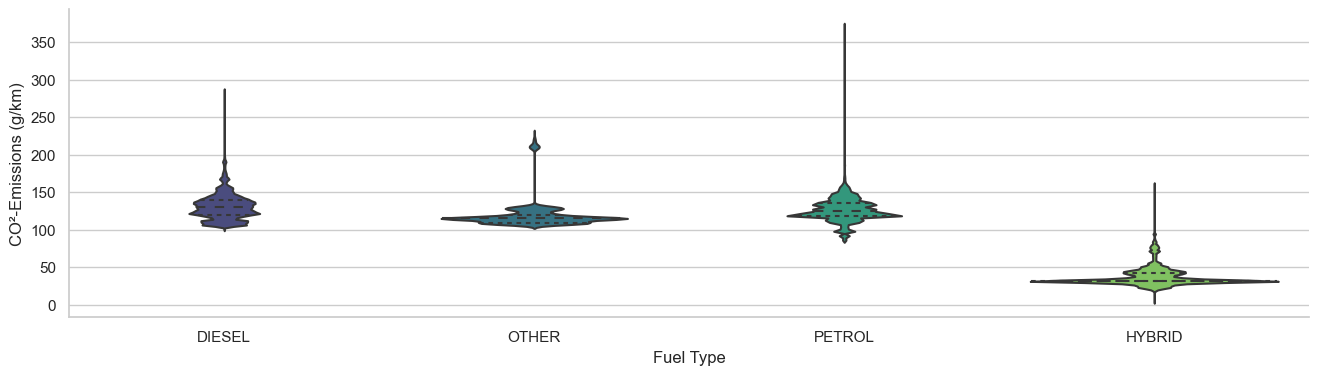

In [111]:
# Filter out categories from 'Ft' with count 0
filtered_categories = df['Ft'].value_counts()[df['Ft'].value_counts() != 0].index
df_filtered = df[df['Ft'].isin(filtered_categories)]

# Define the order of desired categories
desired_categories_order = ['DIESEL', 'OTHER', 'PETROL', 'HYBRID']

# Create a Violinplot for 'Ewltp (g/km)' separated by 'Ft'
plt.figure(figsize=(16, 4))
sns.violinplot(x='Ft', y='Ewltp_g/km', data=df_filtered, inner='quartile', palette='viridis', order=desired_categories_order)
plt.title('', loc="left", pad=20, fontweight="bold", fontsize=20)
plt.xlabel('Fuel Type')
plt.ylabel('CO²-Emissions (g/km)')
sns.despine(top=True, right=True)
plt.show()


The depicted violin plots and histograms offer a visual exploration of CO² emissions ('Ewltp_g/km') across various fuel types ('Ft'). In the violin plots above, the distribution of emissions for each fuel type is illustrated. Slimmer violin shapes, as observed in 'DIESEL' and 'PETROL', suggest relatively lower variance, while broader shapes in 'OTHER' and 'HYBRID' indicate higher variability. The central markers within each violin represent the median emissions for the respective fuel types.

In the next figure, the superimposed Histogram unveils the frequency distribution of CO² emissions. Noteworthy patterns emerge: 'DIESEL' showcases a concentrated distribution with a distinct peak, 'PETROL' displays a broader distribution with a prominent peak, and 'OTHER' maintains a more even and wider spread. 'HYBRID' exhibits a unique narrow distribution with a characteristic peak at lower emissions.


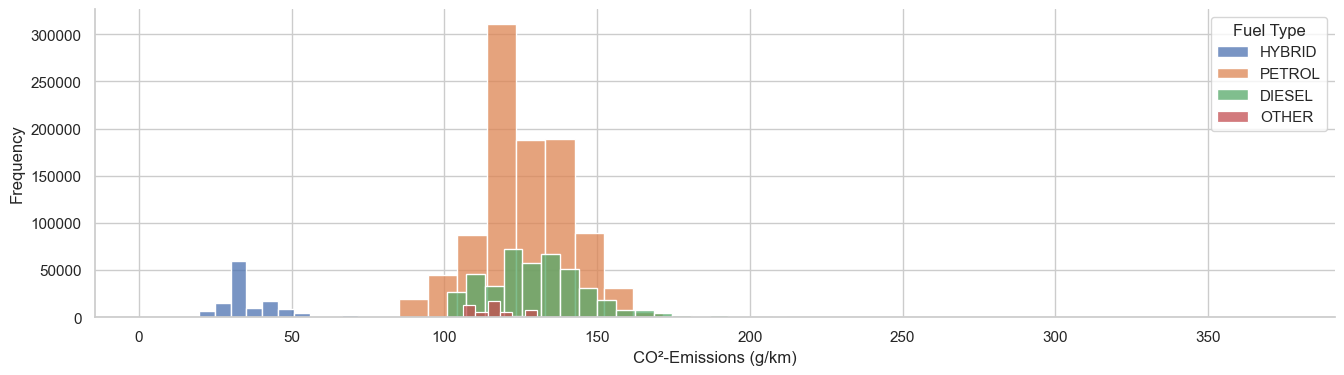

Ft,DIESEL,HYBRID,OTHER,PETROL
count,432688.00,132251.00,52378.00,972431.00
mean,131.00,37.39,119.85,126.73
std,17.44,12.33,19.61,16.45
min,101.00,4.00,106.00,85.00
25%,120.00,31.00,109.00,118.00
50%,130.00,32.00,115.00,125.00
75%,140.00,42.00,120.00,135.00
max,285.00,160.00,228.00,373.00


In [112]:
# Overlayed histogram with desired order
plt.figure(figsize=(16, 4))
desired_categories_order = ['OTHER', 'DIESEL', 'PETROL', 'HYBRID']

for fuel_type in reversed(desired_categories_order):
    sns.histplot(df_filtered[df_filtered['Ft'] == fuel_type]['Ewltp_g/km'], label=fuel_type, kde=False, bins=30, palette="viridis")

plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('CO²-Emissions (g/km)')
plt.ylabel('Frequency')
plt.legend(title='Fuel Type')
sns.despine(top=True, right=True)
plt.show()

# Group the DataFrame by 'Ft' ('Fuel Type') and obtain descriptive statistics
summary_by_fuel_type = df_filtered.groupby('Ft')['Ewltp_g/km'].describe().T

# Filter out categories with Count=0
summary_by_fuel_type_filtered = summary_by_fuel_type.loc[:, summary_by_fuel_type.loc['count'] > 0]

# Create an HTML table
display(summary_by_fuel_type_filtered)




A detailed examination, considering the 8-value summary, provides additional insights:

- **'DIESEL'** exhibits low standard deviation and variance, signifying a relatively consistent emission pattern. The median is at 131.00, reflecting a central tendency.
- **'PETROL'** also displays low standard deviation and variance, along with a sharper histogram peak at a median of 126.73.
- **'OTHER'** and **'HYBRID'** present higher variances, implying broader distributions. 'HYBRID' stands out with the lowest median emissions at 37.39.
- In the Histogram, **'OTHER'** consistently maintains a more even and wider spread across emissions. While it does not necessarily indicate lower emissions on average, it suggests a broader and more diverse distribution of CO² emissions within the 'OTHER' fuel type.

In conclusion, these visualizations enhance our understanding of the distribution and characteristics of CO² emissions for different fuel types. 'DIESEL' and 'PETROL' exhibit specific patterns, while 'OTHER' and 'HYBRID' demonstrate broader variance. 'OTHER' consistently displays lower emissions, providing valuable insights into the environmental impact of distinct fuel types.


### **CO² emissions by fuel mode**

The presented violin plots and Histograms provide a visual representation of CO² emissions ('Ewltp_g/km') based on different fuel modes ('Fm'). In the left plot, the violin plots illustrate the distribution of emissions for each fuel mode. Narrow violin shapes in 'B' and 'F' suggest low variance, while broader shapes in 'H' and 'M' indicate higher variance. The central markings represent the median values of emissions for each mode.

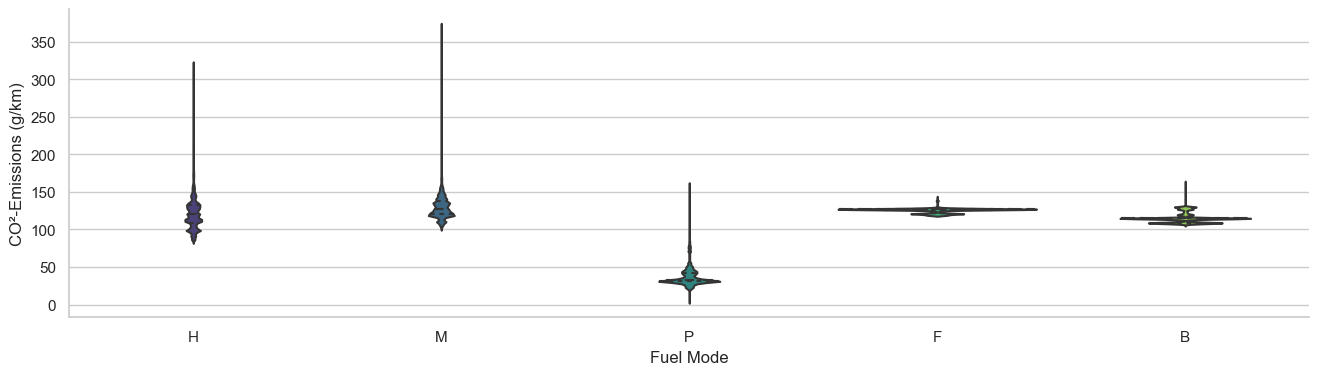

In [113]:
# Convert 'Fm' to string
df['Fm'] = df['Fm'].astype(str)

# Remove rows where 'Fm' has the value 'E'
df_filtered = df[df['Fm'] != 'E']

# Violinplot for 'Fm' separated by 'Fuel Mode' ('Fm') excluding 'E'
plt.figure(figsize=(16, 4))
sns.violinplot(x='Fm', y='Ewltp_g/km', data=df_filtered, inner='quartile', palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold", fontsize=20)
plt.xlabel('Fuel Mode')
plt.ylabel('CO²-Emissions (g/km)')
sns.despine(top=True, right=True)
plt.show()

When we take a look at the next figure, the **overlaid Histogram** displays a frequency distribution of CO² emissions. Notably, 'B' exhibits a narrow distribution with a distinct peak, while 'F' presents a broader distribution with a sharp peak. 'P' shows low frequencies and a narrow distribution. 'H' and 'M' display broader distributions with varying peaks.

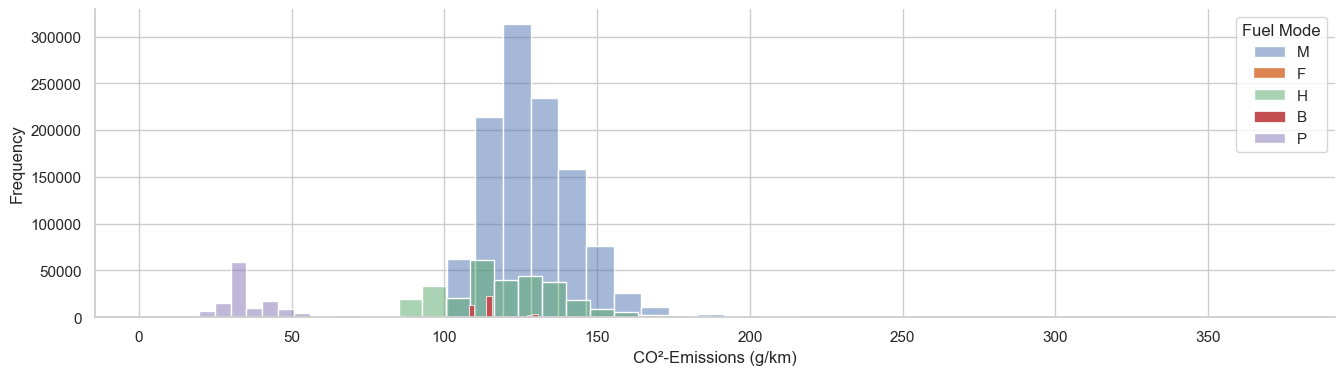

In [114]:
# Overlayed histogram for 'Fm' ('Fuel Mode') with emphasized values for 'B' and 'F'
plt.figure(figsize=(16, 4))

# Sort unique values by average CO² emission
sorted_fuel_modes = df_filtered.groupby('Fm')['Ewltp_g/km'].mean().sort_values(ascending=False).index

for fuel_mode in sorted_fuel_modes:
    if fuel_mode in ['B', 'F']:
        alpha_value = 1  # Emphasized values for 'B' and 'F'
    else:
        alpha_value = 0.5
    sns.histplot(df_filtered[df_filtered['Fm'] == fuel_mode]['Ewltp_g/km'], label=fuel_mode, kde=False, bins=30, alpha=alpha_value, palette="viridis")

plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('CO²-Emissions (g/km)')
plt.ylabel('Frequency')
plt.legend(title='Fuel Mode')
sns.despine(top=True, right=True)
plt.show()


A comparison with the **8-value summary** further elucidates these patterns:

- 'B' demonstrates low standard deviation and variance, with a median of 115.00 and a small interquartile range.
- 'F' exhibits low standard deviation, low variance, and a median of 127.00, with a sharper histogram peak.
- 'H' and 'M' display higher variances and broader distributions.
- 'P' maintains consistent and low CO2 emissions.

In summary, these plots provide insights into the distribution and characteristics of CO2 emissions for different fuel modes. 'B' and 'F' seem to show specific patterns, while 'H' and 'M' exhibit broader variance, and 'P' consistently displays low emissions.


In [115]:
# Group the DataFrame by 'Fm' ('Fuel Mode') and obtain descriptive statistics
summary_by_fuel_mode = df_filtered.groupby('Fm')['Ewltp_g/km'].describe().T

# Filter out categories with Count=0
summary_by_fuel_mode_filtered = summary_by_fuel_mode.loc[:, summary_by_fuel_mode.loc['count'] > 0]

# Create summary
display(summary_by_fuel_mode_filtered)



Fm,B,F,H,M,P
count,46408.00,2454.00,300696.00,1107939.00,132251.00
mean,115.52,125.71,121.65,129.92,37.39
std,6.44,3.08,21.37,15.35,12.33
min,106.00,119.00,85.00,101.00,4.00
25%,109.00,126.00,109.00,120.00,31.00
50%,115.00,127.00,120.00,127.00,32.00
75%,115.00,127.00,132.00,138.00,42.00
max,163.00,143.00,320.00,373.00,160.00


### **Comparative analysis of CO² emissions by Manufacturer**

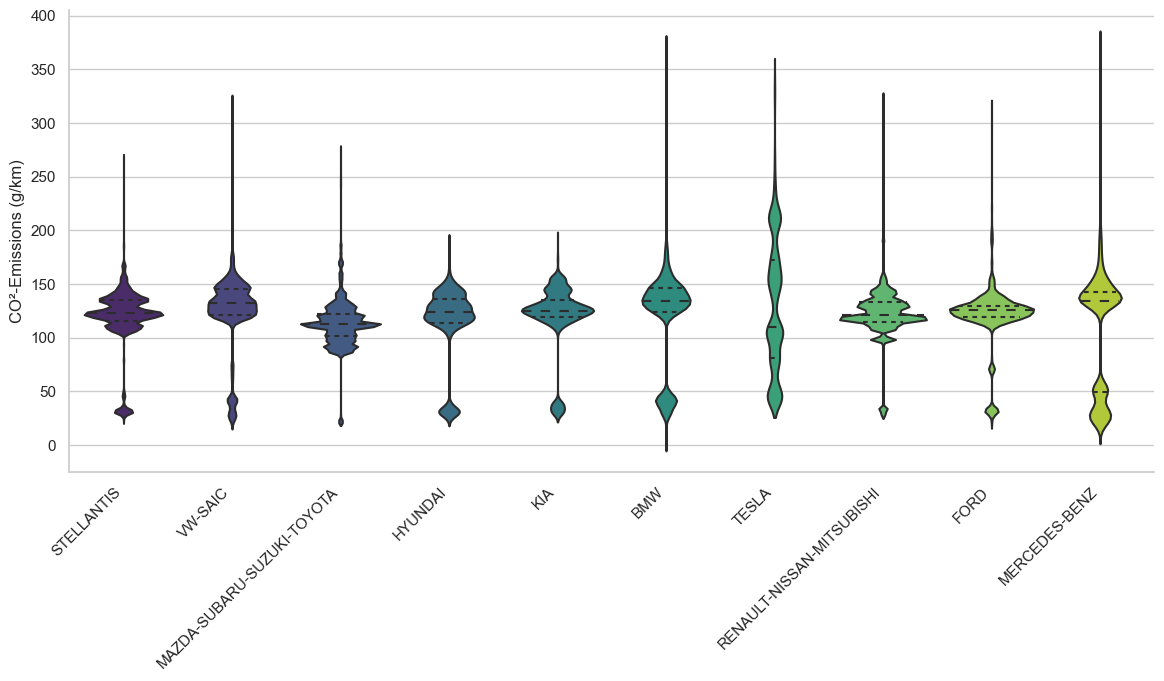

Mp,BMW,FORD,HYUNDAI,KIA,MAZDA-SUBARU-SUZUKI-TOYOTA,MERCEDES-BENZ,RENAULT-NISSAN-MITSUBISHI,STELLANTIS,TESLA,VW-SAIC
count,65550.00,45176.00,42517.00,39558.00,138220.00,50575.00,407971.00,568603.00,13553.00,218025.00
mean,120.37,120.69,115.94,120.75,113.46,106.39,121.84,119.86,129.34,125.74
std,43.69,27.27,34.17,31.05,20.73,56.16,21.34,27.41,61.46,35.74
min,4.00,22.00,26.00,29.00,22.00,14.00,28.00,24.00,44.00,21.00
25%,124.00,119.00,114.00,119.00,102.00,49.00,115.00,116.00,81.00,121.00
50%,134.00,126.00,124.00,125.00,113.00,134.00,121.00,123.00,110.00,132.00
75%,146.00,130.00,136.00,135.00,122.00,143.00,133.00,135.00,172.00,145.00
max,372.00,315.00,188.00,191.00,275.00,373.00,325.00,267.00,342.00,320.00


In [116]:
# Violinplot for 'Mp' ('Manufacturer') excluding 'E'
plt.figure(figsize=(14, 6))
sns.violinplot(x='Mp', y='Ewltp_g/km', data=df_filtered, inner='quartile', palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('')
plt.ylabel('CO²-Emissions (g/km)')
sns.despine(top=True, right=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.show()


summary_by_category = df.groupby('Mp')['Ewltp_g/km'].describe().T

# Display summary by category
display(summary_by_category)


Let us deepen our understanding of our target variable, the carbon dioxide (CO²) emissions, measured in grams per kilometer ('Ewltp_g/km') by a detailed exploration, across various automotive manufacturers ('Mp'). Utilizing violin plot visualizations and 8-value summary statistics, the analysis aims to uncover patterns, variations, and potential outliers within the emissions data. Notably, it's crucial to highlight that all electric vehicles have been excluded from the dataset in former steps, significantly impacting the results, especially for manufacturers prominently associated with electric vehicle production, such as TESLA. Let us summarize the main insights:

**Manufacturer Averages:**
- TESLA emerges with the highest average CO² emissions, standing at 129.34 g/km, closely followed by VW-SAIC at 125.74 g/km.
- Manufacturers such as MAZDA-SUBARU-SUZUKI-TOYOTA and STELLANTIS demonstrate relatively lower average emissions, at 106.39 g/km and 113.46 g/km, respectively.

**Variability in Emissions:**
- TESLA and STELLANTIS exhibit wider variability in CO² emissions, as denoted by the broader shapes of their violin plots.
- HYUNDAI, KIA, and MERCEDES-BENZ, conversely, showcase narrower violin shapes, indicating a more concentrated distribution of emission values.

**Outlier Analysis:**
- TESLA and VW-SAIC prominently display higher outlier values, evidenced by the extended "tails" in their violin plots. This infers the presence of specific vehicles within these categories characterized by exceptionally high CO² emissions.

**Manufacturer Groups Overview:**
- BMW, FORD, HYUNDAI, KIA, and MERCEDES-BENZ share analogous average CO² emissions.
- MAZDA-SUBARU-SUZUKI-TOYOTA exhibits a slightly lower average emission. 
- TESLA and VW-SAIC stand out with higher average emissions, with TESLA presenting a wider distribution.

**Quartile Comparison:**
- TESLA and VW-SAIC present notably higher upper quartiles (75%), suggesting a more significant proportion of vehicles with elevated emissions in these categories.

**Identifying Trends in TESLA and VW-SAIC:**
- The asymmetrical violin shapes for TESLA and VW-SAIC suggest potential variations within these manufacturers, possibly stemming from different subcategories or distinct vehicle models.

**Range of Values:**
- Minimum and maximum CO² emission values demonstrate considerable variation among manufacturers, with TESLA showcasing the highest maximum value.

Conclusion: This segment of the report underscores critical insights into the distribution and variation of CO² emissions across diverse automotive manufacturers. The exclusion of all electric vehicles from the dataset significantly impacts the results, particularly for manufacturers like TESLA, renowned for their production of electric vehicles. Understanding these contextual nuances is imperative for interpreting the findings accurately. Further detailed analyses and exploration of potential influencing factors are recommended in subsequent sections of the report to provide a comprehensive understanding of the observed patterns.


## **Distribution of numerical features by CO²-etiquette**

In [117]:
# Categorization of the target variable
def label_category(emission):
    if emission <= 100:
        return 'A'
    elif 101 <= emission <= 120:
        return 'B'
    elif 121 <= emission <= 140:
        return 'C'
    elif 141 <= emission <= 160:
        return 'D'
    elif 161 <= emission <= 200:
        return 'E'
    elif 201 <= emission <= 250:
        return 'F'
    else:
        return 'G'

# Applying the function to the 'Ewltp (g/km)' column for categorization
df['Ewltp_category'] = df['Ewltp_g/km'].apply(label_category)

# Drop the 'Ewltp (g/km)' column
df = df.drop("Ewltp_g/km", axis=1)

# Display DataFrame information
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1589748 entries, 183427 to 7896715
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Mp              1589748 non-null  object 
 1   Cr              1589748 non-null  object 
 2   m_kg            1589748 non-null  float64
 3   W_mm            1589748 non-null  float64
 4   At1_mm          1589748 non-null  float64
 5   Ft              1589748 non-null  object 
 6   Fm              1589748 non-null  object 
 7   ec_cm3          1589748 non-null  float64
 8   ep_KW           1589748 non-null  float64
 9   z_Wh/km         1589748 non-null  float64
 10  IT              1589748 non-null  int32  
 11  Erwltp_g/km     1589748 non-null  float64
 12  Fc              1589748 non-null  float64
 13  Er_km           1589748 non-null  float64
 14  Ewltp_category  1589748 non-null  object 
dtypes: float64(9), int32(1), object(5)
memory usage: 188.0+ MB


### **Number of vehicles by CO² etiquette**

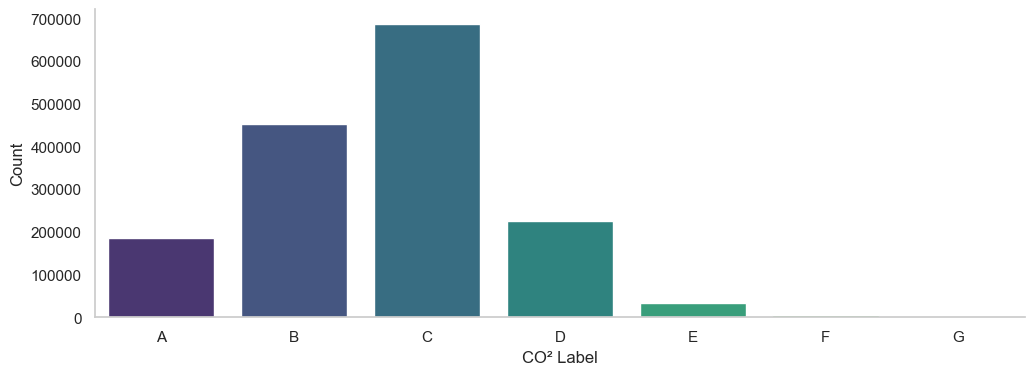

,CO² Label,Count
0,C,686973
1,B,452121
2,D,225878
3,A,185011
4,E,33519
5,F,4813
6,G,1433


In [118]:
# Set Seaborn style without grid lines
sns.set(style="whitegrid", rc={"axes.grid": False})

# Countplot for 'Ewltp_category' in alphabetical order
plt.figure(figsize=(12, 4))
sns.countplot(x='Ewltp_category', data=df, palette='viridis', order=sorted(df['Ewltp_category'].unique()))
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('CO² Label')
plt.ylabel('Count')
sns.despine(top=True, right=True)

plt.show()

# Table of values per category
table_data = df['Ewltp_category'].value_counts().reset_index()
table_data.columns = ['CO² Label', 'Count']
display(table_data)


The next bar plot provides a simple and comprehensive view of the frequency distribution of vehicles based on their CO² labels, which correspond to specific emission classes. Let's delve into the details:

- The most prevalent CO² label is 'C', with emissions falling within the range of 121 to 140 g/ CO²/km. This class is dominant, encompassing 686,973 vehicles and indicating that a substantial portion of the analyzed vehicles emit CO² within this moderate range.
- Following closely is the 'B' category, representing emissions from 101 to 120 g/ CO²/km. With 452,121 vehicles falling into this class, it signifies a significant presence of vehicles with relatively lower CO² emissions.
- The 'D' category, with emissions ranging from 141 to 160 g/ CO²/km, is the next most frequent, accounting for 225,878 vehicles. This class represents vehicles with emissions falling within a specific moderate range.
- Moving to lower frequency, the 'A' category, indicating emissions of 100 g/CO²/km or less, encompasses 185,011 vehicles. This suggests a considerable number of vehicles with the lowest CO² emissions.
- Categories 'E', 'F', and 'G' represent emissions ranging from 161 to 200 g/CO²/km, 201 to 250 g/CO²/km, and over 250 g/CO²/km, respectively. These categories exhibit notably lower frequencies: 'E' has 33,519 vehicles, 'F' has 4,813 vehicles, and 'G' has 1,433 vehicles. These lower frequencies signify a relative scarcity of vehicles with higher CO² emissions in the dataset.


### **Distribution of vehicle width ('W_mm') by CO²-etiqette**

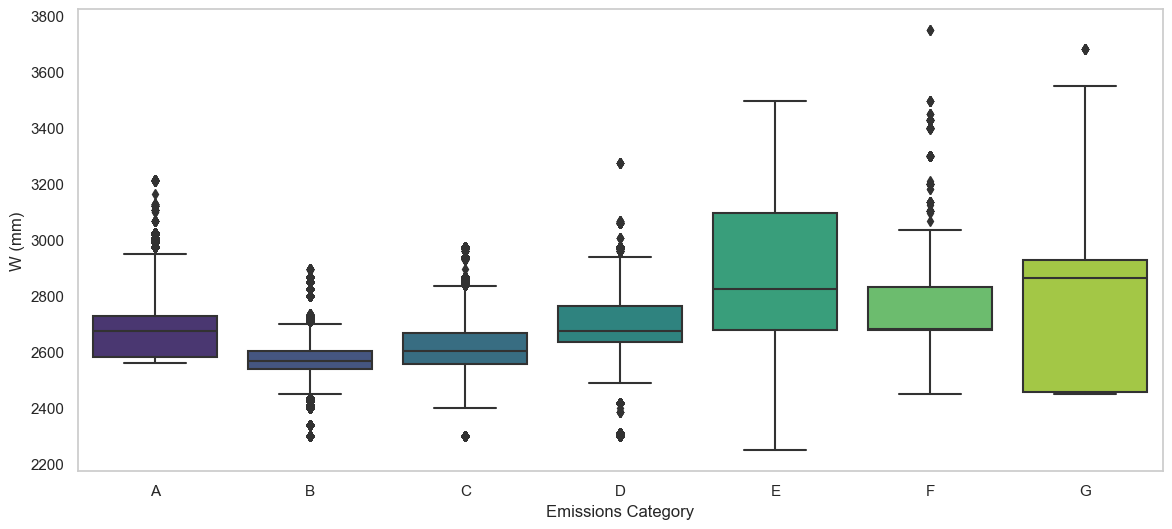

Ewltp_category,A,B,C,D,E,F,G
count,185011.00,452121.00,686973.00,225878.00,33519.00,4813.00,1433.00
mean,2692.65,2549.07,2621.82,2688.86,2893.85,2746.75,2770.94
std,118.00,102.13,82.85,109.00,262.82,219.08,238.17
min,2560.00,2300.00,2300.00,2300.00,2250.00,2450.00,2450.00
25%,2583.00,2539.00,2558.00,2636.00,2679.00,2679.00,2459.00
50%,2675.00,2570.00,2605.00,2675.00,2826.00,2681.00,2864.00
75%,2730.00,2604.00,2670.00,2765.00,3098.00,2832.00,2930.00
max,3216.00,2898.00,2975.00,3275.00,3498.00,3750.00,3682.00


In [119]:
# Convert 'Ewltp_category' to categorical data type
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Set Seaborn style without grid lines
sns.set(style="whitegrid", rc={"axes.grid": False})

# Boxplot for 'Ewltp_category' on x and 'W (mm)' on y
plt.figure(figsize=(14, 6))
sns.boxplot(x='Ewltp_category', y='W_mm', data=df, palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('Emissions Category')
plt.ylabel('W (mm)')

plt.show()

# Convert EWltp to category
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Create summary
summary_by_ewltp_category = df.groupby('Ewltp_category')["W_mm"].describe().T

# Show summary
display(summary_by_ewltp_category)



The boxplot illustrates the distribution of vehicle width ('W_mm') within each emission category. Here's how we can interpret them based on the provided data:

- **Box Extent (Interquartile Range):** The height of the box in each plot represents the interquartile range (IQR), indicating the middle 50% of the data. Categories 'E', 'F', and 'G' have taller boxes, suggesting a broader range of vehicle widths within these emission categories.
- **Line Inside the Box (Median):** The line inside each box represents the median vehicle width. While Category 'C' has a notable median width, 'E', 'F', and 'G' exhibit higher median values, indicating wider vehicles on average.
- **Whiskers (Minimum and Maximum):** The whiskers extend to the minimum and maximum values within a certain range. Category 'G' has the longest whiskers, suggesting the widest overall span of vehicle widths. However, 'E' and 'F', also display extended whiskers, indicating greater variability in widths within these categories.
- **Evaluation of Outliers:** Outliers, are the individual data points outside the whiskers. In our case vehicles with CO²-Etiquette 'A', 'B', 'C', 'D', 'E', and 'F' show the most outliers, signifying extreme values and further emphasizing the variability in vehicle widths within these emission categories. 

    The reported maximum vehicle width of 3750 mm, while exceeding the typical dimensions of standard passenger cars limited to 2.55 meters, is considered realistic and representative. 

    These outlier values are likely associated with specific vehicle types, potentially specialized or industrial vehicles, which can have larger dimensions beyond standard passenger cars. Given the size of the dataset and the limited number of such extreme values, we consider the data as realistic and representative of the diversity in vehicle dimensions within different emission categories. Despite the standard limitation for passenger cars, the presence of larger vehicles is expected, and the dataset's overall integrity is maintained. 


### **Distribution of vehicle weight ('m_kg') by CO²-etiquette**

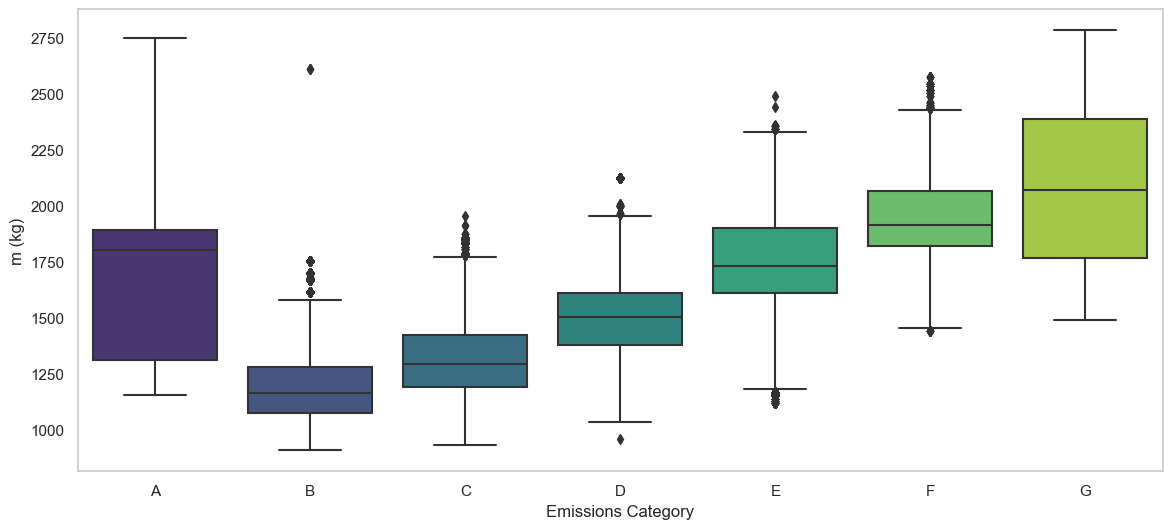

Ewltp_category,A,B,C,D,E,F,G
count,185011.00,452121.00,686973.00,225878.00,33519.00,4813.00,1433.00
mean,1715.15,1187.35,1319.53,1494.30,1770.78,1953.49,2074.71
std,376.74,165.89,161.61,158.83,206.58,225.92,345.15
min,1155.00,910.00,935.00,959.00,1120.00,1440.00,1493.00
25%,1313.00,1074.00,1190.00,1380.00,1610.00,1820.00,1770.00
50%,1805.00,1165.00,1293.00,1504.00,1734.00,1917.00,2070.00
75%,1895.00,1280.00,1425.00,1611.00,1900.00,2065.00,2390.00
max,2751.00,2610.00,1955.00,2125.00,2489.00,2576.00,2785.00


In [120]:
# Boxplot for 'm (kg)' on x and 'W (mm)' on y
plt.figure(figsize=(14, 6))
sns.boxplot(x='Ewltp_category', y='m_kg', data=df, palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('Emissions Category')
plt.ylabel('m (kg)')
plt.show()

# Convert 'Ewltp_category' to categorical data type
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Create an 8-value summary
summary_by_ewltp_category = df.groupby('Ewltp_category')['m_kg'].describe().T

# Display the summary
display(summary_by_ewltp_category)



Continuing from the analysis of vehicle widths, the examination of vehicle weights ('m_kg') within different emission categories provides further insights. The boxplots illustrate distinct characteristics among the categories.

- **Box Extent (Interquartile Range:** Building on the discussion of vehicle width, the patterns in vehicle weights echo some of the trends observed in width distributions. Categories 'C', 'D', 'E', 'F', and 'G' exhibit broader interquartile ranges, indicating a wider variety of vehicle weights within these emission categories. The transition from vehicle width to weight seamlessly underscores the interconnected nature of these attributes.
- **Line inside the Box (Median):** Surprisingly, Category 'A' stands out with a high median weight, suggesting that vehicles in this category tend to be heavier on average. This unexpected finding prompts a closer examination of the data, emphasizing the importance of considering multiple vehicle attributes for a comprehensive analysis.
- **Whiskers (Minimum and Maximum):** When comparing the whiskers, Categories 'D', 'E', 'F', and 'G' present longer spans, pointing to a more extensive range of vehicle weights. On the other hand, Category 'A' exhibits extended whiskers, emphasizing the variability in weights within this particular emission category.
- **Evaluation of Outliers:** Outliers, denoted by individual data points beyond the whiskers, are observed across several categories, notably in 'A' and 'F'. These outliers highlight extreme values and reinforce the understanding that emission categories encompass a diverse range of vehicle weights.

    Addressing the concern of outliers, the reported maximum weight of 2751 kg in Category 'A' is considered realistic. Such outliers likely represent specific vehicle types designed for specialized purposes, illustrating the importance of acknowledging and interpreting extreme values within a broader context. Despite these outliers, the dataset remains representative, capturing the diverse spectrum of weights within different emission categories while maintaining overall integrity.


### **Distribution of engine capacities ('ec_cm3') by CO²-etiquette**

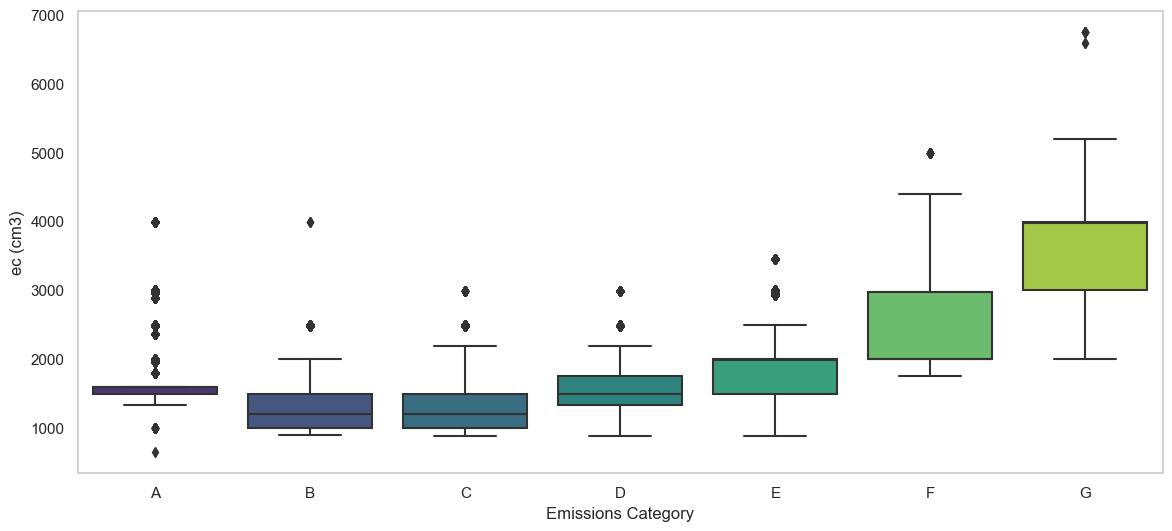

Ewltp_category,A,B,C,D,E,F,G
count,185011.00,452121.00,686973.00,225878.00,33519.00,4813.00,1433.00
mean,1672.23,1269.53,1328.30,1509.13,1960.79,2424.02,3783.37
std,368.67,300.59,319.66,327.30,454.43,588.96,762.06
min,647.00,898.00,875.00,875.00,875.00,1749.00,1995.00
25%,1490.00,999.00,999.00,1332.00,1499.00,1997.00,2996.00
50%,1598.00,1199.00,1199.00,1498.00,1984.00,1997.00,3982.00
75%,1598.00,1499.00,1499.00,1749.00,1997.00,2967.00,3996.00
max,3996.00,3996.00,2993.00,2993.00,3456.00,5000.00,6749.00


In [121]:
# Convert 'Ewltp_category' to categorical data type
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Set Seaborn style without grid lines
sns.set(style="whitegrid", rc={"axes.grid": False})

# Boxplot for 'Ewltp_category' on x and 'ec (cm3)' on y
plt.figure(figsize=(14, 6))
sns.boxplot(x='Ewltp_category', y='ec_cm3', data=df, palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('Emissions Category')
plt.ylabel('ec (cm3)')
plt.show()

# Convert 'Ewltp_category' to categorical data type
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Create an 8-value summary
summary_by_ewltp_category = df.groupby('Ewltp_category')['ec_cm3'].describe().T

# Display the summary
display(summary_by_ewltp_category)



Continuing the exploration, delving into engine capacities ('ec_cm3') within distinct CO² emission categories unveils nuanced characteristics depicted through the boxplots.

- **Box Extent (Interquartile Range):** Echoing the analysis of vehicle width and weight, the interquartile range in engine capacities highlights distinct patterns. Categories 'C,' 'D,' 'E,' 'F,' and 'G' present broader interquartile ranges, signifying a diverse spectrum of engine capacities within these emission categories.
- **Line Inside the Box (Median):** A noteworthy revelation surfaces as Category 'A' exhibits a higher median engine capacity, signaling that, on average, vehicles in this category tend to house larger engines. This unexpected finding beckons a closer examination of the data, emphasizing the intricate interplay among various vehicle attributes.
- **Whiskers (Minimum and Maximum):** Comparing whisker lengths, Categories 'D,' 'E,' 'F,' and 'G' unveil extended spans, suggesting a wider range of engine capacities. In contrast, Category 'A' reveals elongated whiskers, underscoring the variability in engine capacities within this particular emission category.
- **Evaluation of Outliers:** Outliers, marked by individual data points beyond the whiskers, manifest across multiple categories, notably in 'A' and 'F.' These outliers underscore extreme values, accentuating the diverse engine capacities encapsulated within different emission categories.

    Addressing concerns about outliers, it's pivotal to acknowledge that the reported maximum engine capacity of 3996 cm3 in Category 'A' aligns with realism. These outliers likely represent specialized vehicle types tailored for specific purposes, underscoring the need to interpret extreme values within a broader context. Despite the outlier presence, the dataset maintains its representativeness, capturing the expansive spectrum of engine capacities within different emission categories while upholding overall data integrity.


### **Distribution of engine power ('ep_kW') by CO²-etiquette**

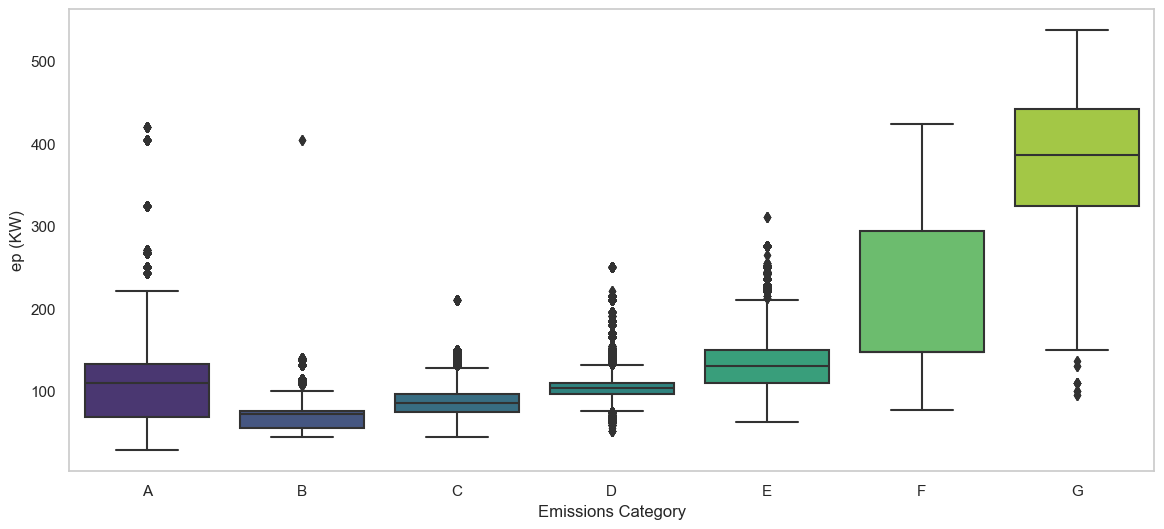

Ewltp_category,A,B,C,D,E,F,G
count,185011.00,452121.00,686973.00,225878.00,33519.00,4813.00,1433.00
mean,112.79,68.70,86.61,105.50,140.51,205.15,382.77
std,46.47,13.60,17.86,19.91,47.27,78.99,82.85
min,28.00,44.00,44.00,51.00,62.00,77.00,95.00
25%,68.00,55.00,74.00,96.00,110.00,147.00,324.00
50%,110.00,72.00,85.00,103.00,130.00,147.00,386.00
75%,133.00,75.00,96.00,110.00,150.00,294.00,441.00
max,420.00,404.00,210.00,250.00,310.00,423.00,537.00


In [122]:
# Boxplot for 'ep (KW)' on x and 'W (mm)' on y
plt.figure(figsize=(14, 6))
sns.boxplot(x='Ewltp_category', y='ep_KW', data=df, palette='viridis')
plt.title('', loc="left", pad=20, fontweight="bold")
plt.xlabel('Emissions Category')
plt.ylabel('ep (KW)')
plt.show()

# Convert 'Ewltp_category' to categorical data type
df['Ewltp_category'] = df['Ewltp_category'].astype('category')

# Create an 8-value summary
summary_by_ewltp_category = df.groupby('Ewltp_category')['ep_KW'].describe().T

# Display the summary
display(summary_by_ewltp_category)


Transitioning from our examination of vehicle weights, the focus now shifts to the power output (ep (KW)), dissected by CO² emission classes. The boxplot serves as our visual guide, unraveling the nuances in power distribution across different emission categories.

- **Box Extent (Interquartile Range):** As we delve into the box heights, Categories 'F' and 'G' emerge with towering boxes, signaling a spectrum of power outputs within these emission realms. Conversely, 'A', 'B', 'C', and 'D' showcase more compact boxes, indicating a more consolidated distribution of power.
- **Line inside the Box (Median):** Plotting the line within each box unveils intriguing findings. Surprisingly, Category 'G' claims the spotlight with the highest median power output, hinting at a fleet of vehicles with a penchant for higher average power. Meanwhile, 'A', 'B', and 'C' assume lower median values, suggesting a relatively modest average power spectrum.
- **Whiskers (Minimum and Maximum):** The whiskers, stretching to encompass the minimum and maximum values, illuminate fascinating trends. Noteworthy is the elongated span of Category 'G', embodying the broadest range of power outputs. In contrast, 'A', 'B', and 'C' unveil shorter whiskers, indicative of a narrower spectrum in power within these emission categories.
- **Evaluation of Outliers:** The outliers, stationed beyond the whiskers, become protagonists in our narrative. Categories 'A', 'B', 'F', and 'G' share the stage with conspicuous outliers, spotlighting instances of extreme power values within these emission categories.

In summation, the exploration into power outputs uncovers a tapestry of patterns across diverse emission classes. 'G' and 'F' take center stage with elevated median values and expansive variability, while 'A', 'B', 'C', and 'D' portray a more clustered power landscape. These revelations enrich our understanding of the multifaceted characteristics intertwined with varying CO² emission classes.


## **Summary**

The exploratory data analysis (EDA) revealed several noteworthy insights within the dataset. Notably, the presence of significant outliers was identified, and distributions and ranges varied substantially based on factors such as fuel type, fuel mode, vehicle type, manufacturer, and CO² labeling. Correlation analyses provided a comprehensive understanding of relationships between variables.

Non-trivial correlations were observed, such as the negative correlation between vehicle weight and CO² emissions per kilometer. Additionally, intricate relationships between various metrics, including expected CO² emissions, fuel consumption, and efficiency, were uncovered. These findings shed light on the complex interplay of factors influencing environmental impact and vehicle characteristics.
The dataset displayed diverse patterns, and correlations were not confined to linear associations. For instance, electric consumption showed a negative correlation with CO² emissions, indicating that electric vehicles with lower emissions tended to have higher electric consumption. The correlation matrix and pairplots facilitated a visual understanding of these relationships.

Distinctive correlations were identified in specific domains, such as vehicle weight exhibiting positive correlations with width, engine capacity, and power. These associations contribute to a more nuanced understanding of the dataset, enhancing the significance of findings in the context of both vehicle characteristics and environmental impact.
In summary, the EDA not only highlighted the existence of outliers and variations in distributions but also uncovered intricate relationships and patterns within the dataset. These insights contribute to a more holistic understanding of the factors influencing CO² emissions and environmental sustainability in the automotive sector.
